<a href="https://colab.research.google.com/github/patelatharva/Analysis_of_Airbnb_property_listings_dataset/blob/master/colab_tuning_booking_price_to_maximize_expected_revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A predictive analysis of how a booking company tune its prices of individual properties to maximize expected revenue

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import glob
import pickle
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
import math
from sklearn.base import clone
!pip install -q scikit-optimize
from skopt import gp_minimize
!pip install -q hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval
!pip install -q keras
!pip install -q tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install -q h5py
from keras.models import load_model
import pprint
import random
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from google.colab import drive

     |████████████████████████████████| 81kB 6.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


## Data Preparation

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/Data Scientist/airbnb/data/boston"

calendar.csv  nn_best_model_1.h5  X_test.csv	      y_train.csv
dtc_best.pkl  nn_best_model.h5	  X_train.csv	      y_train_sample.csv
gb_best.pkl   reviews.csv	  X_train_sample.csv
listings.csv  xgb_best.pkl	  y_test.csv


In [0]:
project_dir = "/content/gdrive/My Drive/Data Scientist/airbnb"
data_dir = project_dir + "/data/boston"

In [0]:
# project_dir = "."

In [0]:
calendar = pd.read_csv(data_dir + "/calendar.csv")
reviews = pd.read_csv(data_dir + "/reviews.csv")
listings = pd.read_csv(data_dir + "/listings.csv")

In [0]:
listings["id"].nunique()

### Transforming 'price' from string to numeric

In [0]:
"""
    Converts price in the string format like "$1,125.00" into numeric value 1125.00
    INPUT:
    - string price in string format
    OUTPUT:
    - float value corresponding to the price or None if the input is not parseable to float
"""
def str_to_num (string):
    if string is not None:
        if type(string) is str and string.startswith('$'):
            return float(string.replace('$', '').replace(',', ''))
        else:
            return None
    else:
        return None
listings_cleaned = pd.concat([listings.drop('price', axis=1), listings["price"].apply(str_to_num)], axis=1)
listings_cleaned['price'].head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

In [0]:
calendar_cleaned = pd.concat([calendar.drop('price', axis=1), calendar["price"].apply(str_to_num)], axis=1)
calendar_cleaned['price'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: price, dtype: float64

### Converting 'avilable' field from string to binary

In [0]:
calendar_cleaned['available'] = calendar_cleaned['available'] == 't'
calendar_cleaned['available'].head()

0    False
1    False
2    False
3    False
4    False
Name: available, dtype: bool

### Converting 'date' from string to datetime format

In [0]:
calendar_cleaned["date"] = pd.to_datetime(calendar_cleaned["date"], format="%Y-%m-%d")

### Converting location field from numeric to categorical

In [0]:
listings_cleaned["location_categorical"] = listings_cleaned.apply(lambda row: str((format(row.latitude, '.2f'), format(row.longitude, '.2f'))), axis=1)

In [0]:
listings_cleaned.location_categorical.head()

0    ('42.28', '-71.13')
1    ('42.29', '-71.13')
2    ('42.29', '-71.14')
3    ('42.28', '-71.12')
4    ('42.28', '-71.14')
Name: location_categorical, dtype: object

### Converting 'amenities' field containing list into separate categorical columns for each amenity in dataframe

In [0]:
list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), listings_cleaned.amenities.iloc[0].split(",")))

['TV',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'Fire Extinguisher',
 'Essentials',
 'Shampoo',
 'Laptop Friendly Workspace']

In [0]:
"""
    Separates the string value of `amenities` attribute in the row, into a list of individual amenities.
    
    INPUT:
    - row : from dataset having amenities attribute
    OUTPUT:    
    - list of amenities derived from the value of `amenities` attribute in row
"""
def separate_amenities(row):
    amenities = row.amenities
    list_to_return = []
    if (amenities is not None and type(amenities) == str):            
        list_to_return = list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), amenities.split(",")))
    if '' in list_to_return:
        list_to_return.remove('')
    return list_to_return
listings_cleaned["amenities_list"] = listings_cleaned.apply(separate_amenities, axis=1)

In [0]:
possible_amenities = listings_cleaned['amenities_list'].apply(pd.Series).stack().unique()
possible_amenities

array(['TV', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises',
       'Pets live on this property', 'Dog(s)', 'Heating',
       'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector',
       'Fire Extinguisher', 'Essentials', 'Shampoo',
       'Laptop Friendly Workspace', 'Internet', 'Air Conditioning',
       'Pets Allowed', 'Carbon Monoxide Detector', 'Lock on Bedroom Door',
       'Hangers', 'Hair Dryer', 'Iron', 'Cable TV', 'First Aid Kit',
       'Safety Card', 'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50', 'Gym', 'Breakfast',
       'Indoor Fireplace', 'Cat(s)', '24-Hour Check-in', 'Hot Tub',
       'Buzzer/Wireless Intercom', 'Other pet(s)', 'Washer / Dryer',
       'Smoking Allowed', 'Suitable for Events', 'Wheelchair Accessible',
       'Elevator in Building', 'Pool', 'Doorman',
       'Paid Parking Off Premises', 'Free Parking on Street'],
      dtype=object)

In [0]:
"""
    Assigns new boolean attribute to the row based on the presence of that amenity in the list.
    Returns updated row with additional attributes corresponding to the amenities added to it.
    
    INPUT:
    - row containing attributes related to the property, including `amenities_list`
    OUTPUT:
    - row containing newly added boolean attributes indicating the presence of each possible type of amenity in the property
"""
def add_amenities_columns (row):
    amenities = set(row.amenities_list)
    for possible_amenity in possible_amenities:
        row["amenity_" + possible_amenity] = possible_amenity in amenities
    return row

listings_cleaned = listings_cleaned.apply(add_amenities_columns, axis=1)

### Identifying the activation date for each property listing

In [0]:
df = calendar_cleaned
df = df.groupby('listing_id', group_keys=False)\
    .apply(lambda x: x[x.available.ne(x.available.shift())])\
    .reset_index(drop=True)
df.head(20)

,listing_id,date,available,price
0,3353,2017-09-05,True,36.0
1,3353,2016-12-30,False,NaN
2,3353,2017-08-18,True,36.0
3,3353,2016-10-12,False,NaN
4,5506,2017-09-05,True,145.0
5,5506,2016-10-10,False,NaN
6,5506,2016-10-03,True,145.0
7,5506,2016-09-30,False,NaN
8,5506,2016-09-28,True,145.0
9,5506,2016-09-25,False,NaN


In [0]:
listing_activation_dates = df[df.available == True].groupby("listing_id")[["listing_id","date"]].min()

In [0]:
listing_activation_dates.sort_values(by=["date"]).head()

,listing_id,date
listing_id,,
530983,530983,2016-09-06
815639,815639,2016-09-06
12726343,12726343,2016-09-06
2776391,2776391,2016-09-06
10524612,10524612,2016-09-06


### Only retaining entries in calendar for each property after its activation date

In [0]:
cal_by_listing_groups = calendar_cleaned.groupby(["listing_id"])

In [0]:
cal_by_listing_groups.head()

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN
365,3075044,2017-08-22,True,65.0
366,3075044,2017-08-21,True,65.0
367,3075044,2017-08-20,True,65.0
368,3075044,2017-08-19,True,75.0
369,3075044,2017-08-18,True,75.0


In [0]:
def select_entries_after_activation_date(g):

    listing_id = g.name
    activation_date_df = listing_activation_dates.query("listing_id == @listing_id")["date"]
    if activation_date_df.shape[0] > 0:        
        activation_date = activation_date_df.iloc[0]
#         print("activatation_date: " + str(activation_date))
#         print(g["date"].dtype)
#         print(type(activation_date))
        return g[g["date"] <= activation_date]
    
    
cal_after_activation_dates =cal_by_listing_groups.apply(select_entries_after_activation_date)

### Select and add necessary variables to be used for predicting occupancy of property at given time of the year

In [0]:
input_vars_from_listings = ["neighbourhood_cleansed", 
#                 "neighbourhood_group_cleansed",
                "city",
                "state",
                "zipcode",
                "market",
                "location_categorical",
                "property_type",
                "room_type",
                "accommodates",
                "bathrooms",
                "bedrooms",
                "beds",
                "bed_type",
                "square_feet",
                "guests_included",
                "minimum_nights",
                "maximum_nights",
                "review_scores_rating",
                "review_scores_accuracy",
                  "review_scores_cleanliness",
                  "review_scores_checkin",
                  "review_scores_communication",
                  "review_scores_location",
                  "review_scores_value",
#                   "jurisdiction_names",
                  "cancellation_policy",
#                   "reviews_per_month",
                  "number_of_reviews"
       ]
amenity_variables = list(map(lambda amenity : "amenity_" + amenity, possible_amenities))
input_vars_from_listings.extend(amenity_variables)


In [0]:
avg_price_by_date = calendar_cleaned.groupby("date")[["date", "price"]].agg(["mean"])

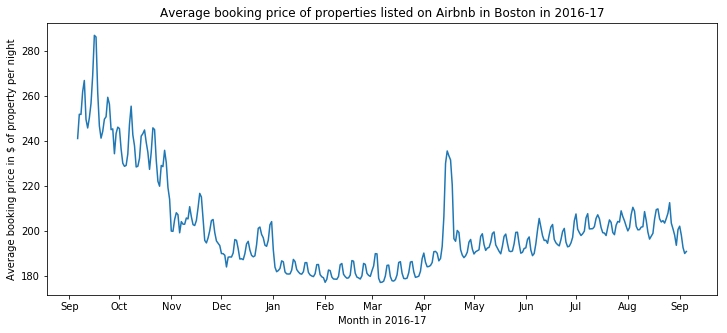

In [0]:
prices_2016_17 = avg_price_by_date[avg_price_by_date.index >= calendar_cleaned["date"].min()][avg_price_by_date.index <= calendar_cleaned["date"].max()]
dates = prices_2016_17.index
months = mdates.MonthLocator()
month_format = mdates.DateFormatter("%b")
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.plot(dates, prices_2016_17)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_format)
yticks = ax.get_yticks()
# ax.set_yticklabels(['{}%'.format(y) for y in yticks])
ax.set_xlabel("Month in 2016-17")
ax.set_ylabel("Average booking price in $ of property per night")
ax.set_title("Average booking price of properties listed on Airbnb in Boston in 2016-17")
plt.show()
fig.savefig(project_dir + "/images/average_booking_price_boston_2016_2017.png")

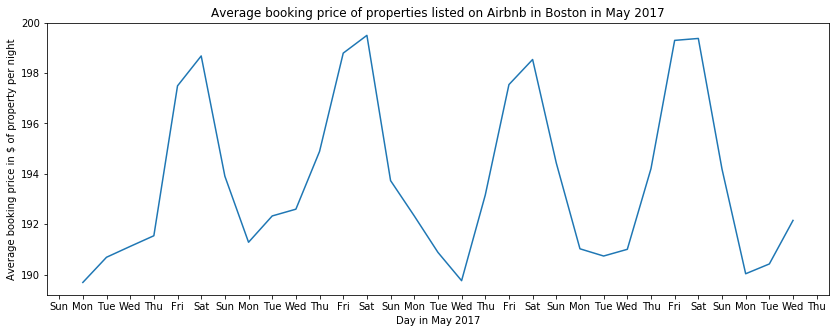

In [0]:
prices_in_summer = avg_price_by_date.loc[pd.date_range('2017-05-01', '2017-05-31')]
dates = prices_in_summer.index
days = mdates.DayLocator()
day_format = mdates.DateFormatter("%a")
fig, ax = plt.subplots()
fig.set_size_inches(14,5)
ax.plot(dates, prices_in_summer)
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(day_format)
yticks = ax.get_yticks()
ax.set_xlabel("Day in May 2017")
ax.set_ylabel("Average booking price in $ of property per night")
ax.set_title("Average booking price of properties listed on Airbnb in Boston in May 2017")
plt.show()
fig.savefig(project_dir + "/images/average_booking_price_boston_may_2017.png")

In [0]:
calendar_cleaned["month"] = calendar_cleaned['date'].dt.month_name()

In [0]:
calendar_cleaned["year"] = calendar_cleaned['date'].dt.year.astype(str)

In [0]:
calendar_cleaned["day_of_week"] = calendar_cleaned['date'].dt.weekday_name

In [0]:
calendar_cleaned["week_of_month"] = np.ceil(calendar_cleaned['date'].dt.day/7).astype(int).astype(str)

In [0]:
calendar_cleaned["week_of_month"].unique()

array(['1', '5', '4', '3', '2'], dtype=object)

In [0]:
df = pd.merge(listings_cleaned, calendar_cleaned, left_on="id", right_on="listing_id", how="inner", suffixes=("_listings", "_calendar"))

In [0]:
# This one consumes too much memory and time, but it can give more accurate price estimates for fulling missing values
# g = df.groupby(["listing_id", "month", "day_of_week"]).apply(lambda x: x.sort_values(by=["date"]))
# g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")
# df = g.reset_index(drop=True)

In [0]:
g = df.groupby(["listing_id"]).apply(lambda x: x.sort_values(by=["date"]))

In [0]:
g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")

In [0]:
df = g.reset_index(drop=True)

In [0]:
input_vars_from_calendar = ["year", "month", "day_of_week", "week_of_month", "price_calendar"]

In [0]:
all_input_vars = input_vars_from_listings + input_vars_from_calendar;

In [0]:
df = df.dropna(subset=["available"])

Select a sample of properties to be used as an environment of alternatives competing with the property to be booked that can have impact on whether the given property gets booked or not.

In [0]:
start_date = df["date"].min()

In [0]:
listing_ids_environment = list(df.query("date == @start_date").drop_duplicates(['listing_id'])["listing_id"].sample(100, random_state=42))

In [0]:
X_with_env = df[all_input_vars + ["listing_id", "date"]].query("listing_id not in @listing_ids_environment")
for listing_id in listing_ids_environment:
    listing_price_availability = df.query("listing_id == @listing_id")[["price_calendar", "available", "date"]]
    X_with_env = pd.merge(X_with_env, listing_price_availability, left_on="date", right_on="date", how="inner", suffixes=("", "_"+str(listing_id)))

### Adding Normalized (Relative) Booking Prices for Properties

- Adding normalized prices for given property and all the properties used in the dataset serving as an indicator of competitive market condition. This will help ML models to easily learn conditions involving relative prices of the properties with much less complexity. 
- I am also retaining the absolute prices for properties in the environment and added one more field for storing total prices of all the properties in environment, so that the model can learn the current demand from the sample of prices from the overall market.

In [0]:
price_columns_for_env = [col for col in X_with_env.columns if col.startswith("price_calendar") and col != "price_calendar"]
price_columns_for_prop_and_env = [col for col in X_with_env.columns if col.startswith("price_calendar")]

In [0]:
X_with_env.loc[:, "total_env_prices"] = X_with_env[price_columns_for_env].sum(axis=1)
for price_column_for_prop_and_env in price_columns_for_prop_and_env:
  X_with_env.loc[:, price_column_for_prop_and_env + "_normalized"] = X_with_env[price_column_for_prop_and_env] / X_with_env["total_env_prices"]

In [0]:
X_with_env = X_with_env.drop(columns=["price_calendar"])

In [0]:
X = X_with_env.sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [0]:
y = df[["available","listing_id", "date"]].query("listing_id not in @listing_ids_environment").sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [0]:
X.shape

(1272390, 378)

In [0]:
y.shape

(1272390, 2)

In [0]:
X.shape[0] == y.shape[0]

True

In [0]:
(X["listing_id"] == y["listing_id"]).all()

True

### Fill missing values in numeric columns with mean of the corresponding column

In [0]:
num_vars = X.select_dtypes(exclude=['object']).copy().columns
def fill_mean (col):
    return col.fillna(col.mean())
X.loc[X.index, num_vars] = X[num_vars].apply(fill_mean, axis=0)

### Convert categorical variables into numeric variables with separate column for missing values

In [0]:
cat_vars = X.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)    

### Splitting data into training and test sets while making sure that no property listing is common between them

In [0]:
unique_listing_ids = X["listing_id"].unique()

In [0]:
np.random.seed(42)
listing_ids_train = np.random.choice(np.array(unique_listing_ids), size= int(0.70 * len(unique_listing_ids)), replace=False)
listing_ids_test = [l for l in unique_listing_ids if l not in listing_ids_train]

In [0]:
X_train = X.query("listing_id in @listing_ids_train")
y_train = y.query("listing_id in @listing_ids_train")

In [0]:
(X_train.index == y_train.index).all()

True

I am using here only a smaller sample of training data to choose hyper parameters using cross validation technique to complete the experiments in timely manner. However, in real world scenario with availability of time, higher computational resources and memory, entire training dataset should be used for choosing optimal hyper parameters.

In [0]:
X_train_sample = X_train.sample(100000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [0]:
(X_train_sample["listing_id"] == y_train_sample["listing_id"]).all()

True

In [0]:
X_train_sample.shape

(100000, 675)

In [0]:
y_train_sample.shape

(100000, 2)

In [0]:
X_test = X.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])
y_test = y.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])

In [12]:
X_train_sample.to_csv(data_dir + "/X_train_sample.csv", index=False)
y_train_sample.to_csv(data_dir + "/y_train_sample.csv", index=False)

NameError: ignored

In [0]:
X_train.to_csv(data_dir + "/X_train.csv", index=False)
y_train.to_csv(data_dir + "/y_train.csv", index=False)

In [0]:
X_test.to_csv(data_dir + "/X_test.csv", index=False)
y_test.to_csv(data_dir + "/y_test.csv", index=False)

In [0]:
y_train["available"].value_counts()/y_train.shape[0]

False    0.510761
True     0.489239
Name: available, dtype: float64

Considering the ratio of samples classified for output True and False, the data looks to be balanced.

### Preparing cross validation splits to into training and test sets while making sure that no property listing is common between them

In [0]:
class MyGridSearchCV(object):
    
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.best_score = -math.inf
        self.best_estimator = None
        self.best_estimator_scores_mean = -math.inf
        self.best_estimator_scores_stdev = -math.inf
        self.best_params= None
        self.cv = cv       
    
    def fit(self, X, y):
        for param_point in self.get_param_grid_points():
            def splits(array, k):
                splits = []
                
                for i in range(k):
                    split_length = math.ceil(len(array)/k)
                    split = []
                    for j in range(i * split_length, (i+1) * split_length):
                        if j < len(array):
                            split.append(array[j])
                        
                    splits.append(split)
                cvs = []
                for i, split in enumerate(splits):
                    train = []
                    for j, other_split in enumerate(splits):
                        if i != j:
                            train += other_split
                    test = [] + split
                    cvs.append((train, test))
                return cvs
                    
            scores_for_point = []
            estimator = clone(self.estimator)
            estimator.set_params(**param_point)
            for l_train, l_test in splits(list(X["listing_id"].unique()), k=self.cv):                
                X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
                X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
                y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
                y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
                estimator.fit(X_train, y_train.values.ravel())
                y_preds = estimator.predict(X_test)
                f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
                f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
                score = min([f1_score_1, f1_score_0])
                scores_for_point.append(score)
                
            mean_score = np.mean(scores_for_point)
            if mean_score > self.best_estimator_scores_mean:
                self.best_estimator_scores_mean = mean_score
                self.best_estimator_scores_stdev = np.std(scores_for_point)
                self.best_estimator = estimator
                self.best_params = self.best_estimator.get_params()
                self.best_score = self.best_estimator_scores_mean
   
            
    def get_param_grid_points(self):
        points = [{}]
        for param, values in self.param_grid.items():
            new_points = []
            for point in points:
                for value in values:                    
                    new_point = point.copy()
                    new_point[param]= value
                    new_points.append(new_point)
            points = new_points
        return points
    
    def print_best(self):
        print("Best score:")
        print(self.best_score)
        print("Best params:")
        print(self.best_params)
        print("Best estimator scores mean:")
        print(self.best_estimator_scores_mean)
        print("Best estimator scores stdev:")
        print(self.best_estimator_scores_stdev)

In [0]:
def my_cross_val_score(estimator, X, y):
    def splits(array, k):
        splits = []

        for i in range(k):
            split_length = math.ceil(len(array)/k)
            split = []
            for j in range(i * split_length, (i+1) * split_length):
                if j < len(array):
                    split.append(array[j])

            splits.append(split)
        cvs = []
        for i, split in enumerate(splits):
            train = []
            for j, other_split in enumerate(splits):
                if i != j:
                    train += other_split
            test = [] + split
            cvs.append((train, test))
        return cvs

    scores_for_point = []
    for l_train, l_test in splits(list(X["listing_id"].unique()), k=5):
        X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
        y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
        X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
        y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])
        estimator.fit(X=X_train, y=y_train.astype('int').values.ravel())
        y_preds = estimator.predict(X_test)
        f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
        f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
        score = min([f1_score_1, f1_score_0])
        scores_for_point.append(score)

    mean_score = np.mean(scores_for_point)
    return mean_score



In [0]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

In [0]:
X_train = pd.read_csv(data_dir + "/X_train.csv")
y_train = pd.read_csv(data_dir + "/y_train.csv")

In [0]:
X_train_sample = pd.read_csv(data_dir + "/X_train_sample.csv")
y_train_sample = pd.read_csv(data_dir + "/y_train_sample.csv")

### Decision Tree Classifier for testing setup

I will be using **Tree of Parzen Estimators** algorithm implemented in **Hyperopt** library for choosing hyper parameters to be evaluated to find the optimal ones that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [0]:
def objective_dtc(params):
    clf = DecisionTreeClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

dtc_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1,6,2)),
    "min_samples_split": hp.choice("min_samples_split", [2*x for x in range(1,11,2)]),
    "max_depth": hp.choice("max_depth", [2**x for x in range(2,11)]),    
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_dtc = space_eval(dtc_param_space, fmin(objective_dtc, dtc_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_dtc)
dtc = DecisionTreeClassifier()
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open(data_dir + '/dtc_best.pkl', 'wb'))

{'max_depth': 512, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42}
score: 0.6220363763486967
{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 18, 'random_state': 42}
score: 0.6346257615695923
{'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42}
score: 0.6389153647896277
{'max_depth': 64, 'min_samples_leaf': 5, 'min_samples_split': 14, 'random_state': 42}
score: 0.6330118900289432
{'max_depth': 64, 'min_samples_leaf': 5, 'min_samples_split': 14, 'random_state': 42}
score: 0.6330118900289432
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 42}
score: 0.5333879412573499
{'max_depth': 1024, 'min_samples_leaf': 3, 'min_samples_split': 10, 'random_state': 42}
score: 0.6296983940700798
{'max_depth': 1024, 'min_samples_leaf': 5, 'min_samples_split': 14, 'random_state': 42}
score: 0.6330118900289432
{'max_depth': 1024, 'min_samples_leaf': 5, 'min_samples_split': 6, 'random_state': 42}
score: 0.6292458

In [0]:
dtc = DecisionTreeClassifier()
# Not the optimal hyper-parameters. Just good enough to train the model in my time constraints.
best_params_dtc = {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 18, 'random_state': 42}
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open(data_dir + '/dtc_best.pkl', 'wb'))


After having evaluated the approximate optimal value for max-depth hyper parameter to be around 16, I am using **Bayesian Optimization** technique implemented in `gp_minimize` method of **Scikit Optimize** package to choose precisely optimal hyper parameters that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [0]:
def objective_dtc(params):
    clf = DecisionTreeClassifier(
        max_depth = params[0],
        min_samples_leaf = params[1],
        min_samples_split = params[2],
        random_state = 42
    )
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print ("Currently evaluating params:")
    print({
      "max_depth": params[0],
      "min_samples_leaf": params[1],
      "min_samples_split": params[2]
    })
    print ("score: " + str(score))
    return -score
start_time = time.time()
dtc_opt_result = gp_minimize(
    func=objective_dtc,
    dimensions=[
        (15, 30),
        (1, 10),
        (2, 20)
    ],
    random_state=42
)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
best_params_list_dtc = dtc_opt_result.x
best_score_dtc = -dtc_opt_result.fun
best_params_dtc = {
    "max_depth": best_params_list_dtc[0],
    "min_samples_leaf": best_params_list_dtc[1],
    "min_samples_split": best_params_list_dtc[2]
}
print ("Best score: " + str(best_score_dtc))
dtc = DecisionTreeClassifier()
best_params_dtc["random_state"] = 42
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open(data_dir + '/dtc_best.pkl', 'wb'))

Currently evaluating params:
{'max_depth': 27, 'min_samples_leaf': 3, 'min_samples_split': 16}
score: 0.634529800318085
Currently evaluating params:
{'max_depth': 24, 'min_samples_leaf': 5, 'min_samples_split': 4}
score: 0.6354855813968447
Currently evaluating params:
{'max_depth': 22, 'min_samples_leaf': 4, 'min_samples_split': 5}
score: 0.6402829158655986
Currently evaluating params:
{'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 15}
score: 0.6361856611613164
Currently evaluating params:
{'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 20}
score: 0.6393042355339641
Currently evaluating params:
{'max_depth': 24, 'min_samples_leaf': 7, 'min_samples_split': 2}
score: 0.6352381685444916
Currently evaluating params:
{'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 9}
score: 0.6414458978961008
Currently evaluating params:
{'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 6}
score: 0.641837941721267
Currently evaluating params:
{'max_dep

## Ensemble Learners

### Extreme Gradient Boosting (XGBoost)

In [0]:
def objective_xgb(params):
    clf = XGBClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

xgb_param_space = {    
    "max_depth": hp.choice("max_depth", range(3, 8, 2)),
    "n_estimators": hp.choice("n_estimators", range(100, 1001, 100)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_xgb = space_eval(xgb_param_space, fmin(objective_xgb, xgb_param_space, algo=tpe.suggest, max_evals=50))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_xgb)
xgb = XGBClassifier()
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(gb, open(data_dir + '/xgb_best.pkl', 'wb'))

{'max_depth': 5, 'n_estimators': 900, 'random_state': 42}
score: 0.6959482061124207
{'max_depth': 5, 'n_estimators': 500, 'random_state': 42}
score: 0.7013311889090483
{'max_depth': 7, 'n_estimators': 500, 'random_state': 42}
score: 0.704247240493697
{'max_depth': 3, 'n_estimators': 600, 'random_state': 42}
score: 0.6844628396178002
{'max_depth': 5, 'n_estimators': 900, 'random_state': 42}
score: 0.6959482061124207
{'max_depth': 7, 'n_estimators': 400, 'random_state': 42}
score: 0.7020884040608999
{'max_depth': 7, 'n_estimators': 100, 'random_state': 42}
score: 0.6981134414994274
{'max_depth': 5, 'n_estimators': 100, 'random_state': 42}
score: 0.6971164218604825
{'max_depth': 5, 'n_estimators': 500, 'random_state': 42}
score: 0.7013311889090483
{'max_depth': 5, 'n_estimators': 300, 'random_state': 42}
score: 0.6984930214839458
{'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
score: 0.6769828426973563
{'max_depth': 7, 'n_estimators': 400, 'random_state': 42}
score: 0.7020884040

KeyboardInterrupt: ignored

In [0]:
xgb = XGBClassifier()
# Using smaller sample of training data as
# with large size of training data caused the system to run out of memory
best_params_xgb = {'max_depth': 7, 'n_estimators': 200, 'random_state': 42}
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_train_sample.drop(columns=["listing_id"]), y=y_train_sample.drop(columns=["listing_id"]).values.ravel())
pickle.dump(xgb, open(data_dir + '/xgb_best.pkl', 'wb'))

### AdaBoost

In [0]:
def objective_ada(params):
    clf = AdaBoostClassifier(DecisionTreeClassifier())
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
ada_param_space = {
    "base_estimator__min_samples_leaf": hp.choice("base_estimator__min_samples_leaf", range(1,6,2)),
    "base_estimator__min_samples_split": hp.choice("base_estimator__min_samples_split", [2*x for x in range(1,11,2)]),
    "base_estimator__max_depth": hp.choice("base_estimator__max_depth", [2**x for x in range(2,11)]),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_ada = space_eval(ada_param_space, fmin(objective_ada, ada_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_ada)
ada = AdaBoostClassifier(DecisionTreeClassifier())
ada.set_params(**best_params_ada)
ada.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(ada, open(data_dir + '/ada_best.pkl', 'wb'))

### Gradient Boost

In [0]:
def objective_gb(params):
    clf = GradientBoostingClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

gb_param_space = {    
    "max_depth": hp.choice("max_depth", range(1, 11, 1)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_gb = space_eval(gb_param_space, fmin(objective_gb, gb_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_gb)
gb = GradientBoostingClassifier()
gb.set_params(**best_params_gb)
gb.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(gb, open(data_dir + '/gb_best.pkl', 'wb'))

In [0]:
gb = GradientBoostingClassifier()
# Not the optimal hyper-parameters. Just good enough to train the model in my time constraints.
best_params_gb = {'max_depth': 5, 'n_estimators': 20, "random_state": 42}
gb.set_params(**best_params_gb)
gb.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(gb, open(data_dir + '/gb_best.pkl', 'wb'))

### Random Forest

In [0]:
def objective_rf(params):
    clf = RandomForestClassifier()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
rf_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 10, 2)),
    "max_depth": hp.choice("max_depth", [2**x for x in range(2,11)]),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_rf = space_eval(rf_param_space, fmin(objective_rf, rf_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_rf)
rf = RandomForestClassifier()
rf.set_params(**best_params_rf)
rf.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(rf, open(data_dir + '/rf_best.pkl', 'wb'))

### Support Vector Machine

In [0]:
def objective_svm(params):
    clf = SVC()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
svm_param_space = {
    "kernel": hp.choice("kernel", ['rbf']),
    "gamma": hp.choice("gamma", [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]),
    "C": hp.choice("C", [0.1, 1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]),
    "random_state": hp.choice("random_state", [42]),
    "probability": hp.choice("probability", [True])
}
start_time = time.time()
best_params_svm = space_eval(svm_param_space, fmin(objective_svm, svm_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_svm)
svm = SVC()
svm.set_params(**best_params_svm)
svm.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(svm, open(data_dir + '/svm_best.pkl', 'wb'))

## Neural Network with Keras

Following setup is done to speed up the execution of Tensorflow using TPU provided by Google Colab.

For deciding number of hidden layers and number of neurons in each layer, I followed following rules of thumb suggested by some ML researches on discussion forums related to machine learning and statistics.
- The number of hidden neurons should be between the size of the input layer and the size of the output layer.
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
- The number of hidden neurons should be less than twice the size of the input layer.  

While these values can be a good starting point, the most optimal values for number and width of hidden layers can be decided by treating those numbers as hyperparameters to be tuned.

In [0]:
def make_model(n_features, learn_rate):
    model = Sequential()    
    
    model.add(Dense(200, input_shape=(n_features,), kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(100, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))        
    
    model.add(Dense(70, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=learn_rate),
                metrics=['acc'])
    print (model.summary())
    return model

In [0]:
nn_model = make_model(len(X_train.drop(columns=["listing_id"]).columns), 0.01)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               135000    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_____________________________________

In [0]:
validation_listing_ids = list(X_train[["listing_id"]].drop_duplicates(["listing_id"]).sample(frac=0.1)["listing_id"])
X_val_nn = X_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
y_val_nn = y_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
X_train_nn = X_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])
y_train_nn = y_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])

I have used Early stopping to prevent the neural network overfit to the training data while being trained on same data through multiple epochs.  
I have also used ModelCheckpoint that saves the weights of last best performing model, so that I can set early stopping patience to greater zero and it allows a few epochs to be executed to confirm that the performance of model on unseen data is unlikely to improve by running any more epochs.

In [0]:
nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=50, verbose=1,
            callbacks=[
                EarlyStopping(monitor='val_loss', verbose=1, patience=5),
                ModelCheckpoint(data_dir + '/nn_best_model.h5', monitor='val_loss', verbose=1)
            ])

In [0]:
nn_model.load_weights(data_dir + "/nn_best_model.h5")

## Prediction & Model Evaluation

In [0]:
X_test = pd.read_csv(data_dir + "/X_test.csv")
y_test = pd.read_csv(data_dir + "/y_test.csv")

### Evaluating Neural Network

In [0]:
nn_model = load_model(data_dir + "/nn_best_model.h5")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
nn_model.evaluate(x=X_test,y=y_test)

381790/381790 [==============================] - 39s 101us/step


[1.813935320654408, 0.5401005788522486]

In [0]:
nn_model.metrics_names

['loss', 'acc']

In [0]:
y_preds_nn = nn_model.predict_classes(X_test)

In [0]:
f1 = f1_score(y_test, y_preds_nn, average="macro")
print ("f1-score: " + str(f1))

f1-score: 0.4564552560400117


In [0]:
nn_model.predict(X_test.iloc[0:5, :])

array([[0.48316222],
       [0.5818155 ],
       [0.6526842 ],
       [0.6613153 ],
       [0.6311892 ]], dtype=float32)

### Evaluating Ensemble Learners

In [0]:
models = {
    "Extreme Gradient Boost": data_dir + "/xgb_best.pkl",
    "Gradient Boost": data_dir + "/gb_best.pkl",
#     "Random Forest": data_dir + "/rf_best.pkl",
#     "Ada Boost": data_dir + "/ada_best.pkl",
#     "SVM": data_dir + "/svm_best.pkl",
    "Single Decision Tree": data_dir + "/dtc_best.pkl"
}


In [11]:
for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    y_preds = model.predict(X_test)
    f1 = f1_score(y_test, y_preds, average="macro")
    print ("Model: " + model_name + " f1-score: " + str(f1))

Model: Extreme Gradient Boost f1-score: 0.7273543786720841
Model: Gradient Boost f1-score: 0.6971056439651757
Model: Single Decision Tree f1-score: 0.6632784384636072


### Model Interpretation

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    pp.pprint(sorted(list(zip(feature_names, clf.feature_importances_)), key=lambda x: x[1], 
reverse=True)[:20])

for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    print("\nModel: " + model_name)
    print("Best Params: ")
    pp.pprint(model.get_params())
    print("Top 10 Feature importances: ")
    print_top10(X_train_sample.columns, model, model.classes_)

## Tuning the booking price of property

### Aim: Maximizing expected revneue from individual properties

Here I tune the booking price of the property by looking at the probability of the property being booked at given price. If the probability is too low, I try increasing it by setting the price the of that property slightly low and see if it increases the probability. My goal is to maximize the profit of the company by maximizing expected revneue from individual properties. 

In [0]:
Sequential.predict_proba = Sequential.predict

In [0]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

As per the economic principle of price elasticity of demand, the quantity of a product demanded should be varying with changes in price like this curve if the demanded quantity is elastic to the price.

![Price Elasticity of Demand Curve](http://wikieducator.org/images/0/0f/Ed1.jpeg)

In our case, the quantity of demand synonymous to the probability of the property being booked and the price is the booking price of the property. Let's try and check if some randomly selected properties from our dataset demonstrates price elasticity for probability of being booked.

### Methods to calculate probability of a property being booked at given normalized price and market condition


In [0]:
nn_model = load_model(data_dir + "/nn_best_model.h5")
def calc_prob_booked_nn(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])
  return 1 - nn_model.predict(df)[0][0]

In [0]:
xgb_clf = pickle.load(open(data_dir + "/xgb_best.pkl", 'rb'))
def calc_prob_booked_xgb(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])  
  return xgb_clf.predict_proba(df)[0][0]

In [0]:
gb_clf = pickle.load(open(data_dir + "/gb_best.pkl", 'rb'))
def calc_prob_booked_gb(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])
  return gb_clf.predict_proba(df)[0][0]

In [0]:
dtc_clf = pickle.load(open(data_dir + "/dtc_best.pkl", 'rb'))
def calc_prob_booked_dtc(row):
  df = pd.DataFrame(data=row.to_dict(), index=[0])  
  return dtc_clf.predict_proba(df)[0][0]

### Price Elasticity for probability of a property getting booked

In [0]:
def calculate_price_elasticity(calc_prob_booked, listing):
  current_normalized_price = listing["price_calendar_normalized"]
  norm_price_1 = current_normalized_price
  price_1 = norm_price_1 * listing["total_env_prices"]
  listing["price_calendar_normalized"] = norm_price_1
  d_1 = calc_prob_booked(listing)
  exp_1 = price_1 * d_1

  norm_price_2 = current_normalized_price * 1.10
  price_2 = norm_price_2 * listing["total_env_prices"]
  listing["price_calendar_normalized"] = norm_price_2
  d_2 = calc_prob_booked(listing)
  exp_2 = price_2 * d_2

  price_change = (price_2 - price_1)/((price_2 + price_1)/2)
  demand_change = (d_2 - d_1)/((d_2 + d_1)/2)
  elasticity = demand_change / -price_change
  return elasticity

In [0]:
def draw_price_elasticity_curves(calc_prob_booked):
  fig, ax = plt.subplots(3, 2, figsize=(15,10))
  sample_listings = [listing for (index, listing) in X_test.sample(6, random_state=42).copy().iterrows()]

  for plot_row in range(0,3):
    for plot_col in range(0,2):  
      listing = sample_listings.pop()
      current_normalized_price = listing["price_calendar_normalized"]
      current_price = int(round(listing["price_calendar_normalized"] * listing["total_env_prices"],0))
      price_upper = current_normalized_price * (1 + 300/100)
      price_lower = current_normalized_price * 0
      normalized_price_range = list(float_range(str(price_lower), str(price_upper), str((price_upper - price_lower)/50)))

      probs = []
      absolute_prices = [listing["total_env_prices"] * normalized_price for normalized_price in normalized_price_range]

      for price in normalized_price_range:
          listing["price_calendar_normalized"] = price
          prob = calc_prob_booked(listing)
          probs.append(prob)

      price_elasticity_curve, = ax[plot_row, plot_col].plot(absolute_prices, probs)
      ax[plot_row, plot_col].set_ylabel('Probability of property being booked')
      ax[plot_row, plot_col].set_xlabel('Booking price of property')
      current_price_line = ax[plot_row, plot_col].axvline(x=current_price, color='g')   

      # Measuring price elasticity
      elasticity = calculate_price_elasticity(calc_prob_booked, listing)

      ax[plot_row, plot_col].legend((current_price_line, price_elasticity_curve), ('Current price = ' +str(current_price), 'Price elasticity ED = ' +str(round(elasticity, 5))))

  plt.show()

### Price elasticity for probability of booking learnt by Neural Network

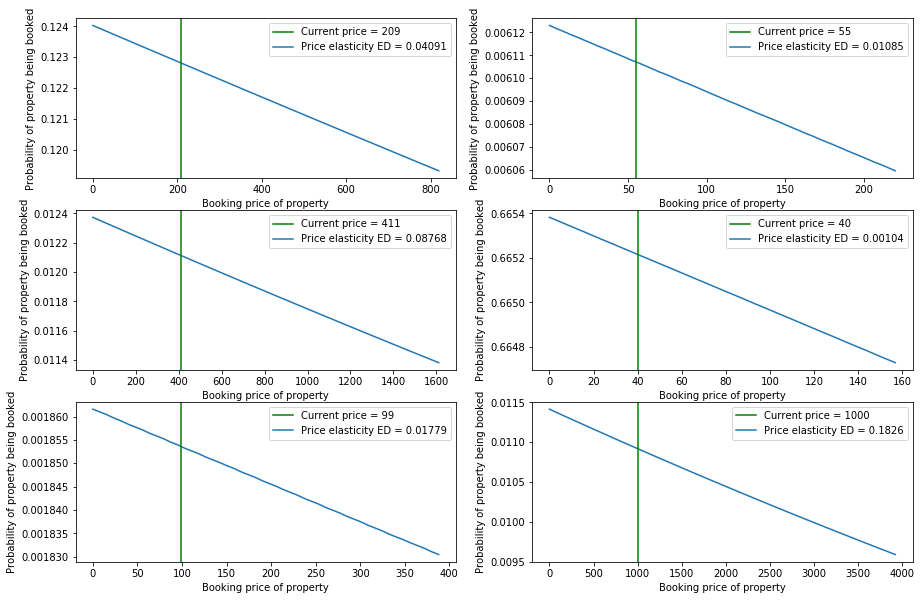

In [0]:
draw_price_elasticity_curves(calc_prob_booked_nn)

As we can see above, choosing some random properties from dataset and plotting relationship between normalized price and probability of getting the property booked shows that they demonstrate price elasticity for probability of the property being booked.

Although the price elasticity curve generated using Neural Network is smooth, it represents that probability of property getting booked is inelastic towards price in very large price range. Such model does not very well represent the real world scenario where demand of property can be inelastic to price within only a small range of price.

In my first iteration of project, I tried using absolute price to evaluate the relationship between probability of property being booked and the price. At that time, I the plot did not follow the price elasticity curve.

One of the assumption in the price elasticity curve is that all the other factors in the market should be held relatively constant and only the price of the property should be varying. Only then the relation between booking probability and price will follow the popular price elasticity curve in wide range of price variation.

The absolute value of price may have been increased in the dataset when the overall demand of properties for booking have increased. In such case, the property might be still getting booked at higher price duing the periods of higher demand. Therefore based on the dataset, the model trained on absolute price will suggest that the probability of booking may also increase when the property price is increased. 

To tackle this issue, I implemented workaround by normalizing the price relative to the sum of booking prices of all the other 100 properties that we are using in our training dataset to represent the competitive market environment conditions. Now we can observe the trend of change in probability along with the change in relative price and see that it shows some price elasticity as expected.

### Price elasticity for probability of booking learnt by Single Decision Tree

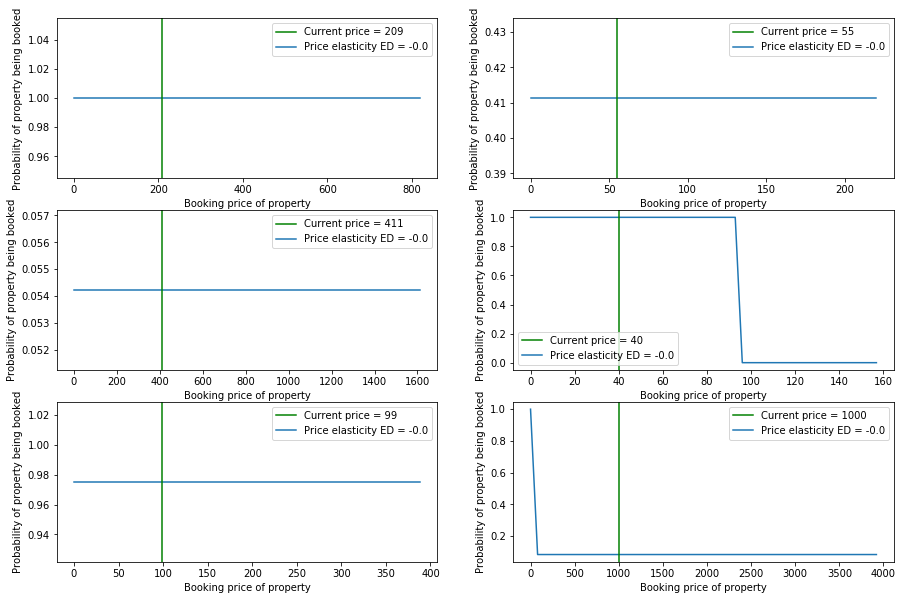

In [0]:
draw_price_elasticity_curves(clac_prob_booked_dtc)

### Price Elasticity for probability of booking learnt by Gradient Boosting with 20 estimators

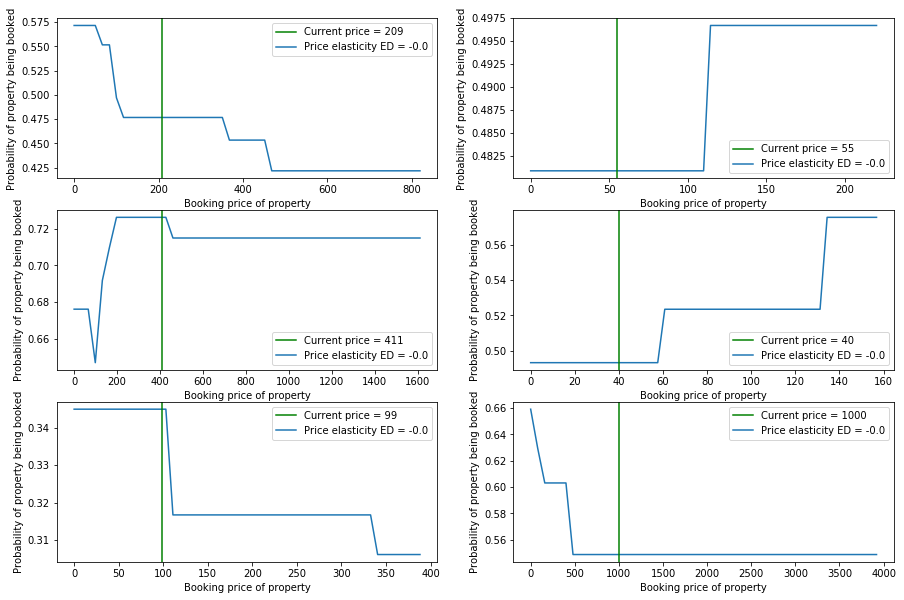

In [0]:
draw_price_elasticity_curves(calc_prob_booked_gb)

### Price Elasticity for probability of booking learnt by Extreme Gradient Boosting (XGBoost)

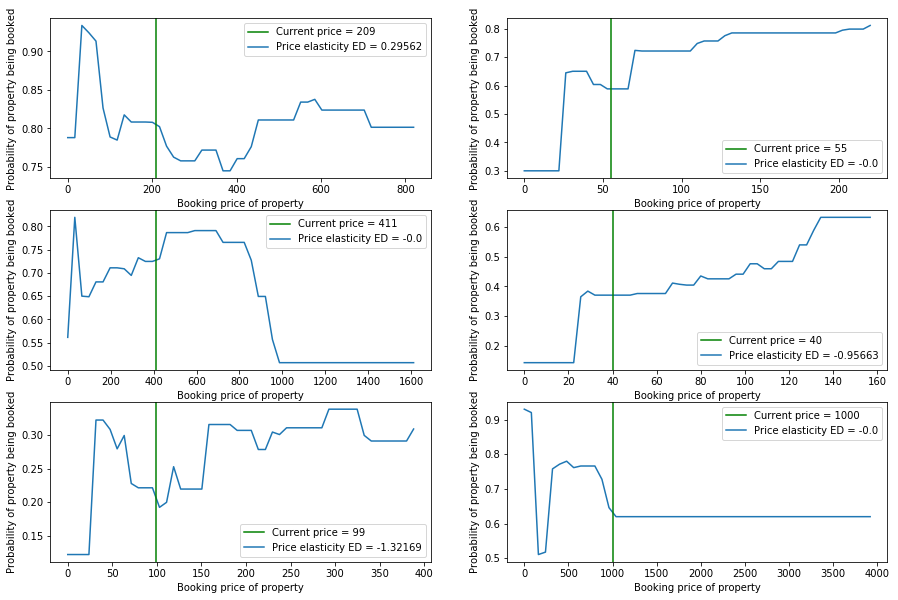

In [0]:
draw_price_elasticity_curves(calc_prob_booked_xgb)

Let's tune prices of the properties that show significant price elasticity for demand.

`get_price_elasticity_curve` function gets price elasticity curve for the probability of property getting booked by calculating the probability from the given calc_prob_booked function within a range values varying from current normalized price of property by specified percentage. It then fits a polynomial curve that fits the points calculated from the probability of property getting booked at that normalized price point it returns that fitted curve as output.

In [0]:
def get_price_elasticity_curve(listing, calc_prob_booked, percentage):
  current_norm_price = listing["price_calendar_normalized"]
  higher_price_normalized = current_norm_price * (1 + (percentage/100))
  lower_price_normalized = max(0, current_norm_price * (1 - (percentage/100)))    
  samples_price_norm = list(float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized - lower_price_normalized)/100)))
  samples_price_norm += list(float_range(str(current_norm_price * (0.95)), str(current_norm_price * (1.05)), str(current_norm_price * (0.1/50))))

  probs = []
  
  for sample_price_norm in samples_price_norm:
    listing["price_calendar_normalized"] = sample_price_norm
    prob = calc_prob_booked(listing)
    probs.append(prob)  

  X = pd.DataFrame({"x" : samples_price_norm})
  y = pd.DataFrame({"y": probs})
  curve = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
  curve.fit(X,y)
  return curve
  
  

In [0]:
def draw_price_elasticity_for_prop(listing, calc_prob_booked, percentage, curve):

    current_normalized_price = listing["price_calendar_normalized"]
    current_price = int(round(listing["price_calendar_normalized"] * listing["total_env_prices"],0))
    price_upper = current_normalized_price * (1 + percentage/100)
    price_lower = current_normalized_price * max(0, (1 - percentage/100))
    normalized_price_range = list(float_range(str(price_lower), str(price_upper), str((price_upper - price_lower)/50)))

    probs = []
    absolute_prices = [listing["total_env_prices"] * normalized_price for normalized_price in normalized_price_range]
    curve_probs = []
    for price in normalized_price_range:
        listing["price_calendar_normalized"] = price
        prob = calc_prob_booked(listing)
        probs.append(prob)       
        df_norm_price = pd.DataFrame(data={"x" : price}, index=[0])
        curve_prob = curve.predict(df_norm_price)[0]
        curve_probs.append(curve_prob)
   
    price_elasticity_curve, = plt.plot(absolute_prices, probs)
    ridge_curve, = plt.plot(absolute_prices, curve_probs)
    
    plt.ylabel('Probability of property being booked')
    plt.xlabel('Booking price of property')
    current_price_line = plt.axvline(x=current_price, color='g')   

    # Measuring price elasticity
#     elasticity = calculate_price_elasticity(calc_prob_booked, listing)

#     plt.legend((current_price_line, price_elasticity_curve), ('Current price = ' +str(current_price), 'Price elasticity ED = ' +str(round(elasticity, 5))))
    plt.legend((current_price_line, ridge_curve), ('Current price = ' +str(current_price), 'Fitted elasticity curve'))
    plt.show()

### Calculating the expected revenue from property while tuning the price

- For each property I first check whether the property follows conventional price elasticity where the probability of the property getting booked increases as its relative price is decreased and only tuned price for those properties that demonstrated such trend.
- Instead of using exact probability predicted by the classifier, I decided to use the one derived from line fitted on the predicted probability values for normalized price range near the current normalized price, so that tuning algorithm has to work with smoothly varying values that smoothes sudden bumps in the probability values often seen to be generated by ensemble learners.

In [0]:
def calc_revenue_at_tuned_price(row, calc_prob_booked):  
    current_price_norm = row["price_calendar_normalized"]
    current_price = current_price_norm * row["total_env_prices"]
    prob_booked = calc_prob_booked(row)    
#     print("price_calendar: " + str(current_price))
    

    percentage_to_check = 20
    higher_price_normalized = current_price_norm * (1 + (percentage_to_check/100))
    lower_price_normalized = max(0, current_price_norm * (1 - (percentage_to_check/100)))    
    curve = get_price_elasticity_curve(listing=row, calc_prob_booked=calc_prob_booked, percentage=20)
    df_lower = pd.DataFrame(data={"x" : lower_price_normalized}, index=[0])
    prob_booked_lower_price = curve.predict(df_lower)[0]
    
    df_higher = pd.DataFrame(data={"x" : higher_price_normalized}, index=[0])
    prob_booked_higher_price = curve.predict(df_higher)[0]   
        
    print ("Checking for price elasticity...")
    row["price_calendar_normalized"] = current_price_norm
    draw_price_elasticity_for_prop(row, calc_prob_booked, percentage_to_check, curve)
    if prob_booked_lower_price > prob_booked and prob_booked > prob_booked_higher_price:
        print("✔ The property follows significant price elasiticity in reasonable price range according to model")
        print ("Probability of being booked at current price: " + str(prob_booked))
        print ("Probability of being booked at higher price: " + str(prob_booked_higher_price))
        print ("Probability of being booked at lower price: " + str(prob_booked_lower_price))
        row["price_calendar_normalized"] = current_price_norm
        current_expected_revenue = current_price * prob_booked        
        print ("")
        print("Current price: " + str(round(current_price, 0)))
        print("Probability of being booked at current price: " + str(prob_booked))
        print("Expected revenue at current price: " + str(current_expected_revenue))       
        
        max_expected_revenue = -math.inf
        prob_at_max = None
        price_at_max = None
        for trial_price_norm in float_range(str(lower_price_normalized), str(higher_price_normalized), str((higher_price_normalized-lower_price_normalized)/100)):
          # Instead of using probability predicted by the classifier,
          # I decided to use the one derived from line fitted on the values
          # in normalized price range near the current normalized price
          # so that I can have a smoothly varying values which avoid sudden
          # bumps in the probability values often seen to be generated by
          # ensemble learners.
#             row["price_calendar_normalized"] = trial_price_norm
#             prob_at_trial_price_norm = calc_prob_booked(row)
            df_trial = pd.DataFrame(data={"x" : trial_price_norm}, index=[0])
            prob_at_trial_price_norm = curve.predict(df_trial)[0]   
            expected_revenue = prob_at_trial_price_norm * trial_price_norm * row["total_env_prices"]
            if expected_revenue > max_expected_revenue:
                max_expected_revenue = expected_revenue
                prob_at_max = prob_at_trial_price_norm
                price_at_max = trial_price_norm * row["total_env_prices"]
                
        print ("Recommended price: " + str(round(price_at_max,0)))
        print ("Probability of booked at recommended price: " + str(np.round(prob_at_max, 5)))
        print ("Expected revenue at recommended price: " + str(np.round(max_expected_revenue,2)))
        print ("Percentage of recommended price change: " + str(np.round(100*(price_at_max - current_price)/current_price, 3)) +"%")
        print ("Percentage of change in expected revenue: " + str(np.round(100*(max_expected_revenue - current_expected_revenue)/current_expected_revenue, 2)) +"%")
        print ("----------------------------------------------------------------")
        return max_expected_revenue
    else:
        print("✘ The property does not follow price elasiticity in reasonable price range according to model")
        return current_price * prob_booked

I decided to tune the prices of properties using Extreme Gradient Boosting model for predicting probability of property being booked under giving time, price and market conditions. The reason is that it shows higher accuracy in terms of F1-score as compared to neural network model. Even though the predicted probability graph while varying normalized price is not as smooth as the one generated by neural network, the more accurate prediction of probabilities for property getting booked leads to more accurate prediction for expected revenue from properties at given price point.

Checking for price elasticity...


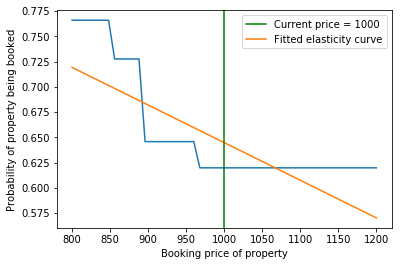

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.61977017
Probability of being booked at higher price: [0.57019103]
Probability of being booked at lower price: [0.71925315]

Current price: 1000.0
Probability of being booked at current price: 0.61977017
Expected revenue at current price: 619.7701692581178
Recommended price: 1200.0
Probability of booked at recommended price: [0.57019]
Expected revenue at recommended price: [684.23]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [10.4]%
----------------------------------------------------------------
Checking for price elasticity...


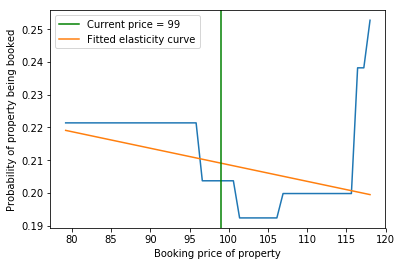

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.20373827
Probability of being booked at higher price: [0.1991193]
Probability of being booked at lower price: [0.21911783]

Current price: 99.0
Probability of being booked at current price: 0.20373827
Expected revenue at current price: 20.170088946819305
Recommended price: 118.0
Probability of booked at recommended price: [0.19932]
Expected revenue at recommended price: [23.6]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.01]%
----------------------------------------------------------------
Checking for price elasticity...


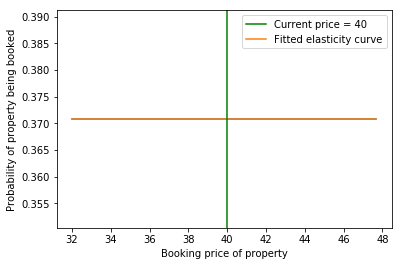

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


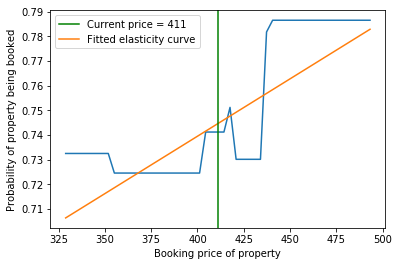

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


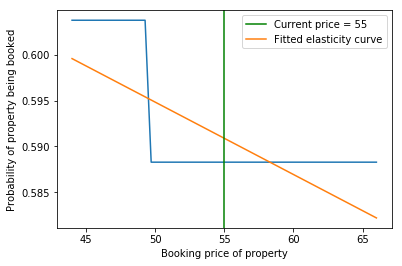

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.5882751
Probability of being booked at higher price: [0.58219129]
Probability of being booked at lower price: [0.59957796]

Current price: 55.0
Probability of being booked at current price: 0.5882751
Expected revenue at current price: 32.35512912273407
Recommended price: 66.0
Probability of booked at recommended price: [0.58237]
Expected revenue at recommended price: [38.31]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [18.4]%
----------------------------------------------------------------
Checking for price elasticity...


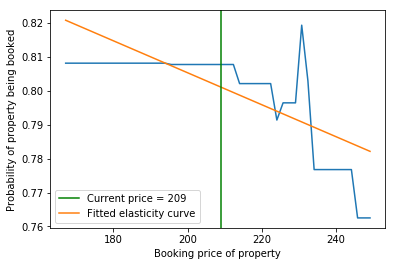

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.807768
Probability of being booked at higher price: [0.78136653]
Probability of being booked at lower price: [0.82082106]

Current price: 209.0
Probability of being booked at current price: 0.807768
Expected revenue at current price: 168.8235093355179
Recommended price: 250.0
Probability of booked at recommended price: [0.78176]
Expected revenue at recommended price: [195.41]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [15.75]%
----------------------------------------------------------------
Checking for price elasticity...


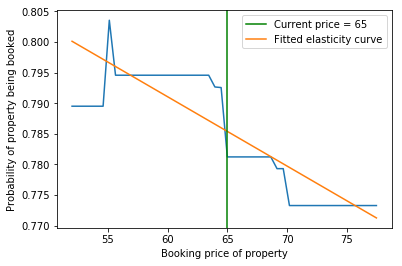

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7812368
Probability of being booked at higher price: [0.77069514]
Probability of being booked at lower price: [0.80010573]

Current price: 65.0
Probability of being booked at current price: 0.7812368
Expected revenue at current price: 50.78039377927779
Recommended price: 78.0
Probability of booked at recommended price: [0.77099]
Expected revenue at recommended price: [59.94]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [18.03]%
----------------------------------------------------------------
Checking for price elasticity...


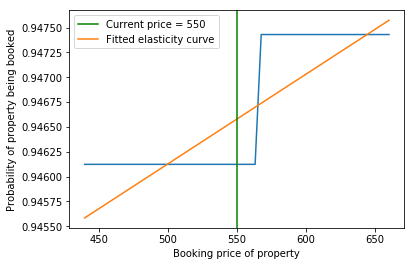

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


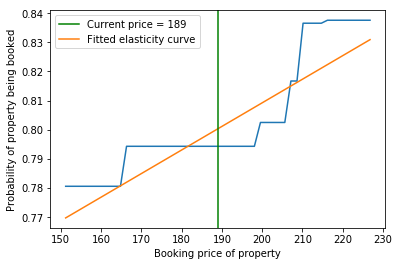

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


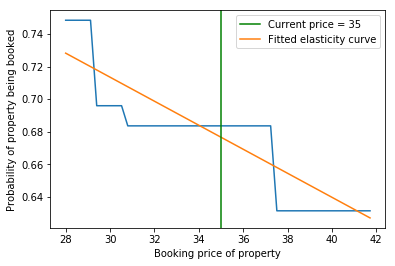

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.6836009
Probability of being booked at higher price: [0.62508915]
Probability of being booked at lower price: [0.72818278]

Current price: 35.0
Probability of being booked at current price: 0.6836009
Expected revenue at current price: 23.926031589508057
Recommended price: 42.0
Probability of booked at recommended price: [0.62612]
Expected revenue at recommended price: [26.21]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [9.54]%
----------------------------------------------------------------
Checking for price elasticity...


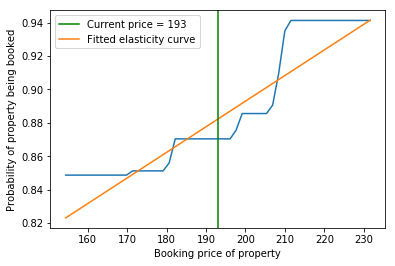

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


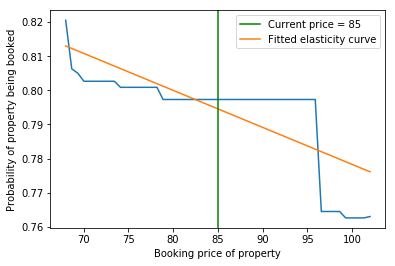

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.79732597
Probability of being booked at higher price: [0.7761368]
Probability of being booked at lower price: [0.81302423]

Current price: 85.0
Probability of being booked at current price: 0.79732597
Expected revenue at current price: 67.7727073431015
Recommended price: 102.0
Probability of booked at recommended price: [0.77614]
Expected revenue at recommended price: [79.17]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [16.81]%
----------------------------------------------------------------
Checking for price elasticity...


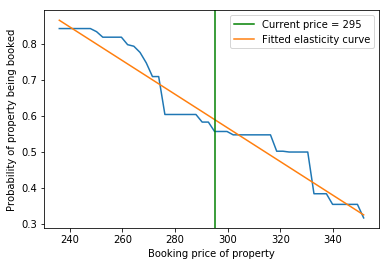

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.5569951
Probability of being booked at higher price: [0.31417593]
Probability of being booked at lower price: [0.86610707]

Current price: 295.0
Probability of being booked at current price: 0.5569951
Expected revenue at current price: 164.31355267763138
Recommended price: 236.0
Probability of booked at recommended price: [0.86611]
Expected revenue at recommended price: [204.4]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [24.4]%
----------------------------------------------------------------
Checking for price elasticity...


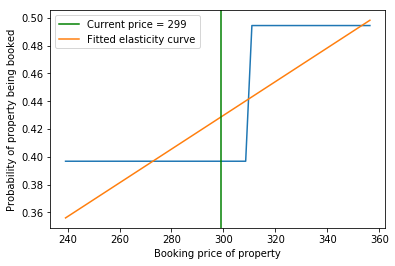

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


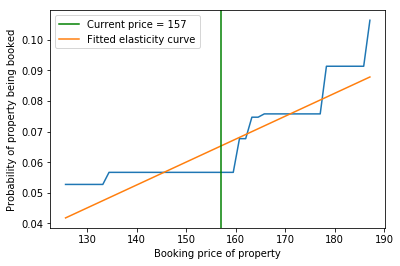

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


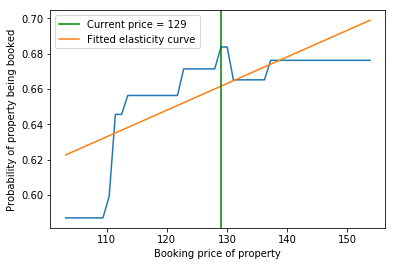

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


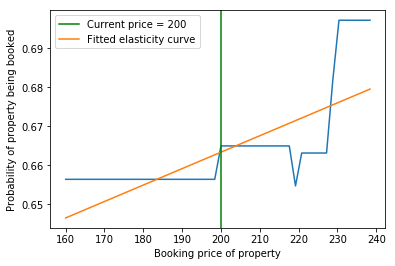

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


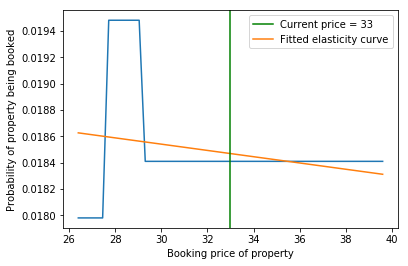

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.018409252
Probability of being booked at higher price: [0.0183111]
Probability of being booked at lower price: [0.01862584]

Current price: 33.0
Probability of being booked at current price: 0.018409252
Expected revenue at current price: 0.6075053215026855
Recommended price: 40.0
Probability of booked at recommended price: [0.01831]
Expected revenue at recommended price: [0.73]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [19.36]%
----------------------------------------------------------------
Checking for price elasticity...


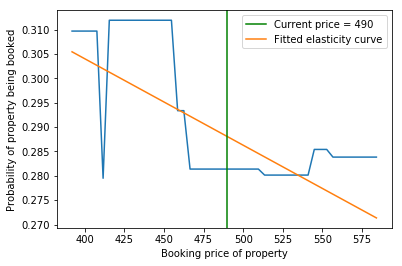

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.2813748
Probability of being booked at higher price: [0.27066108]
Probability of being booked at lower price: [0.30542843]

Current price: 490.0
Probability of being booked at current price: 0.2813748
Expected revenue at current price: 137.87365794181824
Recommended price: 586.0
Probability of booked at recommended price: [0.27101]
Expected revenue at recommended price: [158.82]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [15.19]%
----------------------------------------------------------------
Checking for price elasticity...


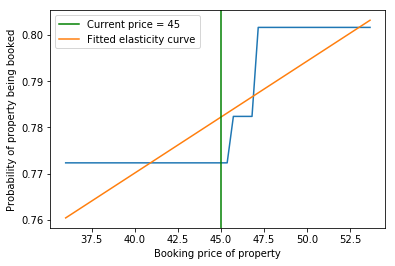

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


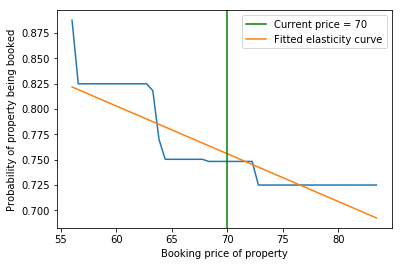

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7481715
Probability of being booked at higher price: [0.68974015]
Probability of being booked at lower price: [0.82175633]

Current price: 70.0
Probability of being booked at current price: 0.7481715
Expected revenue at current price: 52.372005581855795
Recommended price: 84.0
Probability of booked at recommended price: [0.69106]
Expected revenue at recommended price: [57.86]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [10.47]%
----------------------------------------------------------------
Checking for price elasticity...


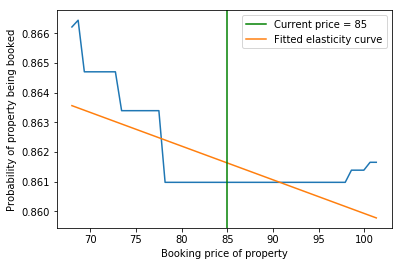

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.8609741
Probability of being booked at higher price: [0.85969541]
Probability of being booked at lower price: [0.86356264]

Current price: 85.0
Probability of being booked at current price: 0.8609741
Expected revenue at current price: 73.1827962398529
Recommended price: 102.0
Probability of booked at recommended price: [0.85973]
Expected revenue at recommended price: [87.4]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [19.43]%
----------------------------------------------------------------
Checking for price elasticity...


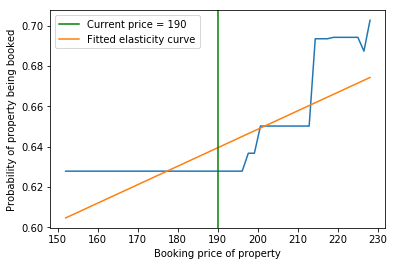

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


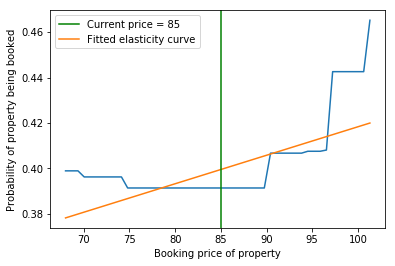

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


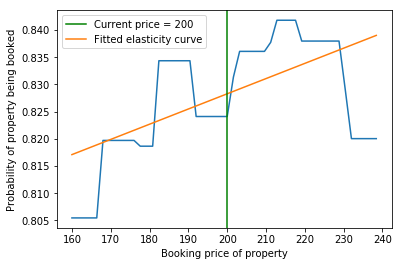

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


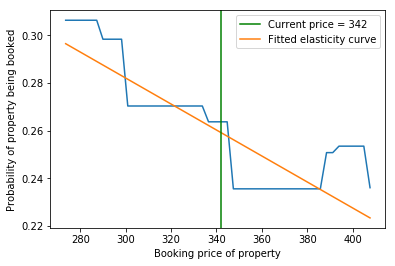

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.26367837
Probability of being booked at higher price: [0.22181709]
Probability of being booked at lower price: [0.2964914]

Current price: 342.0
Probability of being booked at current price: 0.26367837
Expected revenue at current price: 90.17800319194795
Recommended price: 409.0
Probability of booked at recommended price: [0.22256]
Expected revenue at recommended price: [91.04]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [0.95]%
----------------------------------------------------------------
Checking for price elasticity...


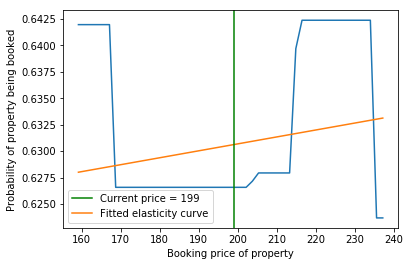

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


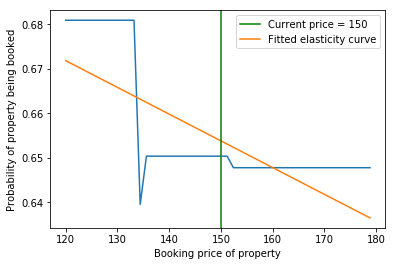

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.65037394
Probability of being booked at higher price: [0.63577213]
Probability of being booked at lower price: [0.67184954]

Current price: 150.0
Probability of being booked at current price: 0.65037394
Expected revenue at current price: 97.55609035491943
Recommended price: 179.0
Probability of booked at recommended price: [0.63613]
Expected revenue at recommended price: [114.12]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [16.98]%
----------------------------------------------------------------
Checking for price elasticity...


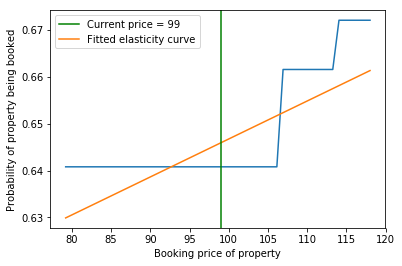

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


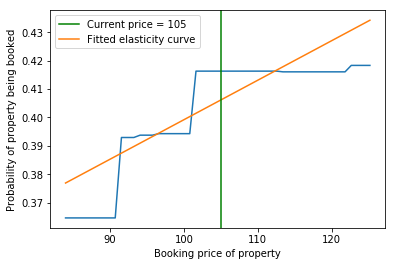

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


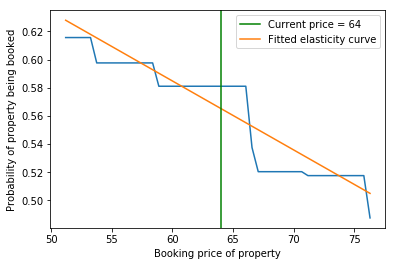

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.5810467
Probability of being booked at higher price: [0.50247672]
Probability of being booked at lower price: [0.62790291]

Current price: 64.0
Probability of being booked at current price: 0.5810467
Expected revenue at current price: 37.18698883056641
Recommended price: 77.0
Probability of booked at recommended price: [0.50373]
Expected revenue at recommended price: [38.56]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [3.69]%
----------------------------------------------------------------
Checking for price elasticity...


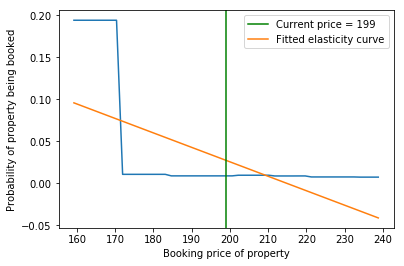

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.0088406205
Probability of being booked at higher price: [-0.04127213]
Probability of being booked at lower price: [0.09585743]

Current price: 199.0
Probability of being booked at current price: 0.0088406205
Expected revenue at current price: 1.7592834830284116
Recommended price: 159.0
Probability of booked at recommended price: [0.09586]
Expected revenue at recommended price: [15.26]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [767.43]%
----------------------------------------------------------------
Checking for price elasticity...


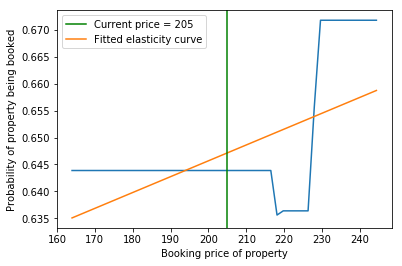

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


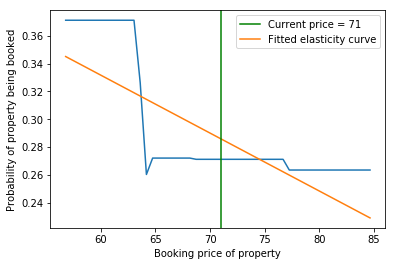

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.2711733
Probability of being booked at higher price: [0.22666515]
Probability of being booked at lower price: [0.34507966]

Current price: 71.0
Probability of being booked at current price: 0.2711733
Expected revenue at current price: 19.253304183483124
Recommended price: 70.0
Probability of booked at recommended price: [0.29061]
Expected revenue at recommended price: [20.3]
Percentage of recommended price change: -1.6%
Percentage of change in expected revenue: [5.45]%
----------------------------------------------------------------
Checking for price elasticity...


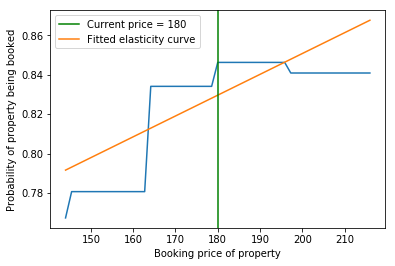

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


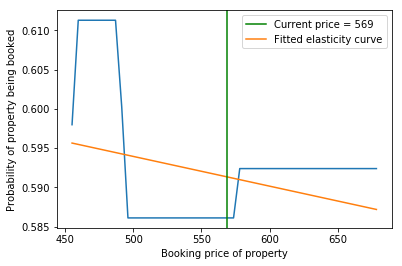

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


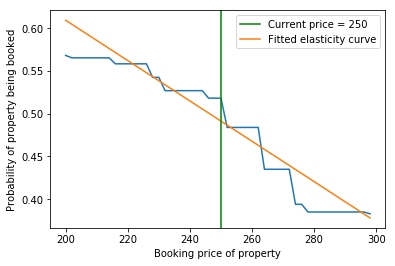

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.51824915
Probability of being booked at higher price: [0.37333699]
Probability of being booked at lower price: [0.60944343]

Current price: 250.0
Probability of being booked at current price: 0.51824915
Expected revenue at current price: 129.5622885227203
Recommended price: 229.0
Probability of booked at recommended price: [0.54097]
Expected revenue at recommended price: [123.88]
Percentage of recommended price change: -8.4%
Percentage of change in expected revenue: [-4.38]%
----------------------------------------------------------------
Checking for price elasticity...


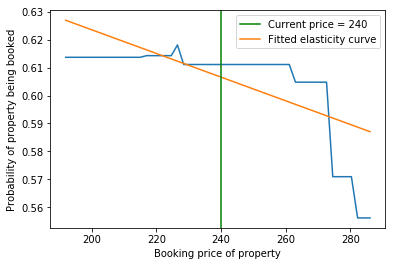

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.61108124
Probability of being booked at higher price: [0.58626153]
Probability of being booked at lower price: [0.62689625]

Current price: 240.0
Probability of being booked at current price: 0.61108124
Expected revenue at current price: 146.65949821472168
Recommended price: 287.0
Probability of booked at recommended price: [0.58667]
Expected revenue at recommended price: [168.4]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [14.82]%
----------------------------------------------------------------
Checking for price elasticity...


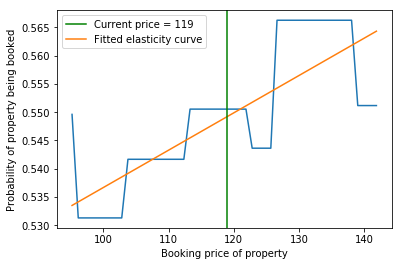

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


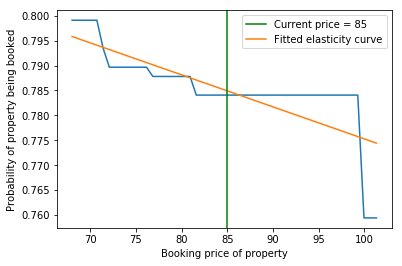

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7840663
Probability of being booked at higher price: [0.77400101]
Probability of being booked at lower price: [0.79582029]

Current price: 85.0
Probability of being booked at current price: 0.7840663
Expected revenue at current price: 66.64563715457916
Recommended price: 102.0
Probability of booked at recommended price: [0.77422]
Expected revenue at recommended price: [78.71]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [18.1]%
----------------------------------------------------------------
Checking for price elasticity...


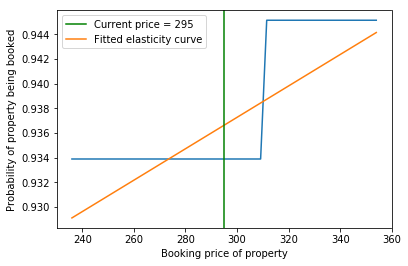

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


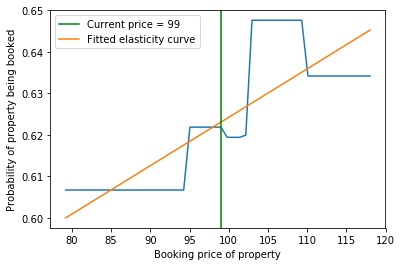

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


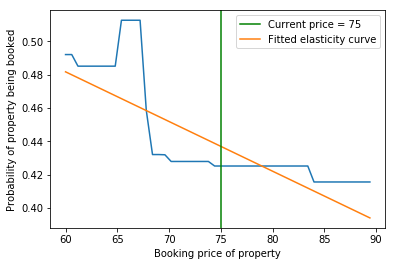

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.42510194
Probability of being booked at higher price: [0.39214104]
Probability of being booked at lower price: [0.48166958]

Current price: 75.0
Probability of being booked at current price: 0.42510194
Expected revenue at current price: 31.882645189762115
Recommended price: 90.0
Probability of booked at recommended price: [0.39304]
Expected revenue at recommended price: [35.26]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [10.58]%
----------------------------------------------------------------
Checking for price elasticity...


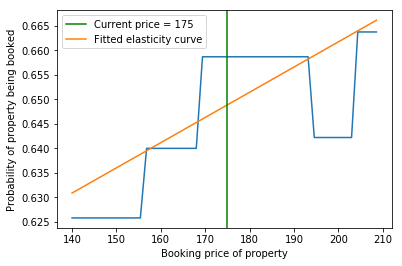

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


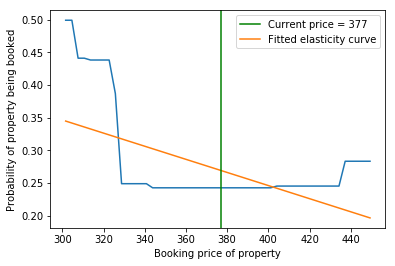

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.24253035
Probability of being booked at higher price: [0.19332861]
Probability of being booked at lower price: [0.34483733]

Current price: 377.0
Probability of being booked at current price: 0.24253035
Expected revenue at current price: 91.43394041061401
Recommended price: 323.0
Probability of booked at recommended price: [0.32363]
Expected revenue at recommended price: [104.44]
Percentage of recommended price change: -14.4%
Percentage of change in expected revenue: [14.22]%
----------------------------------------------------------------
Checking for price elasticity...


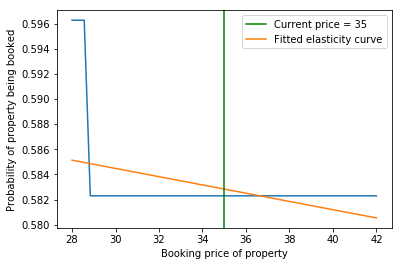

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.58229536
Probability of being booked at higher price: [0.58053876]
Probability of being booked at lower price: [0.58513122]

Current price: 35.0
Probability of being booked at current price: 0.58229536
Expected revenue at current price: 20.38033753633499
Recommended price: 42.0
Probability of booked at recommended price: [0.58058]
Expected revenue at recommended price: [24.3]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [19.25]%
----------------------------------------------------------------
Checking for price elasticity...


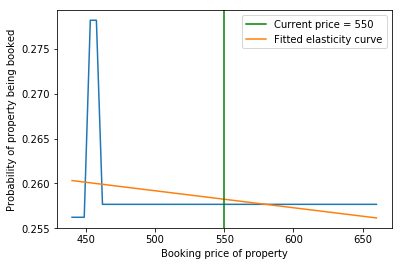

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.25765902
Probability of being booked at higher price: [0.25614351]
Probability of being booked at lower price: [0.26031068]

Current price: 550.0
Probability of being booked at current price: 0.25765902
Expected revenue at current price: 141.71245992183685
Recommended price: 660.0
Probability of booked at recommended price: [0.25614]
Expected revenue at recommended price: [169.05]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [19.29]%
----------------------------------------------------------------
Checking for price elasticity...


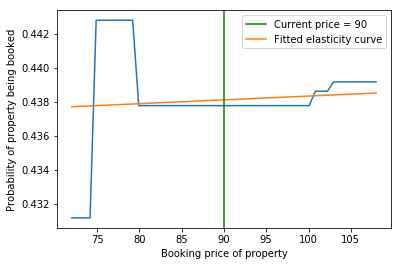

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


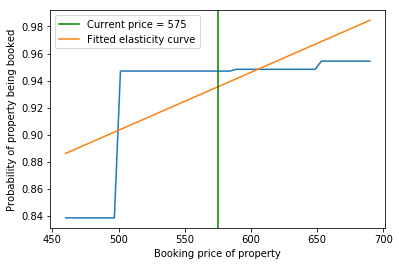

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


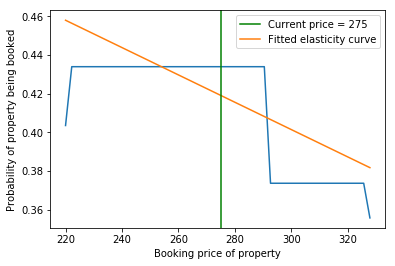

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.43396813
Probability of being booked at higher price: [0.3802141]
Probability of being booked at lower price: [0.4579871]

Current price: 275.0
Probability of being booked at current price: 0.43396813
Expected revenue at current price: 119.34123486280441
Recommended price: 329.0
Probability of booked at recommended price: [0.38099]
Expected revenue at recommended price: [125.31]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [5.]%
----------------------------------------------------------------
Checking for price elasticity...


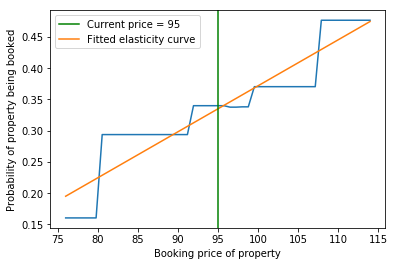

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


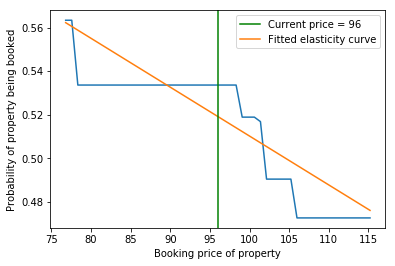

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.53362024
Probability of being booked at higher price: [0.47608161]
Probability of being booked at lower price: [0.56225572]

Current price: 96.0
Probability of being booked at current price: 0.53362024
Expected revenue at current price: 51.227542877197266
Recommended price: 115.0
Probability of booked at recommended price: [0.47608]
Expected revenue at recommended price: [54.84]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [7.06]%
----------------------------------------------------------------
Checking for price elasticity...


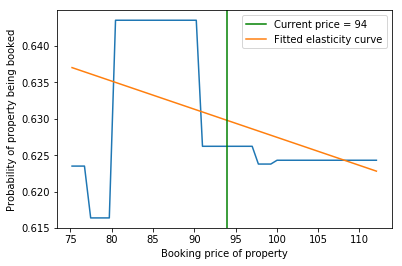

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.6262218
Probability of being booked at higher price: [0.62251454]
Probability of being booked at lower price: [0.63704007]

Current price: 94.0
Probability of being booked at current price: 0.6262218
Expected revenue at current price: 58.86484694480896
Recommended price: 112.0
Probability of booked at recommended price: [0.62266]
Expected revenue at recommended price: [70.]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [18.92]%
----------------------------------------------------------------
Checking for price elasticity...


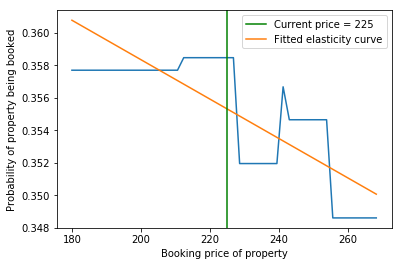

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.3584745
Probability of being booked at higher price: [0.34985567]
Probability of being booked at lower price: [0.36077898]

Current price: 225.0
Probability of being booked at current price: 0.3584745
Expected revenue at current price: 80.65676093101503
Recommended price: 269.0
Probability of booked at recommended price: [0.34996]
Expected revenue at recommended price: [94.18]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [16.76]%
----------------------------------------------------------------
Checking for price elasticity...


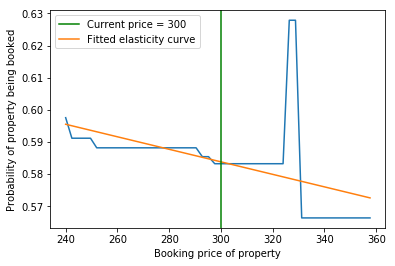

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.5832231
Probability of being booked at higher price: [0.57211947]
Probability of being booked at lower price: [0.59549621]

Current price: 300.0
Probability of being booked at current price: 0.5832231
Expected revenue at current price: 174.9669313430786
Recommended price: 359.0
Probability of booked at recommended price: [0.57235]
Expected revenue at recommended price: [205.36]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.37]%
----------------------------------------------------------------
Checking for price elasticity...


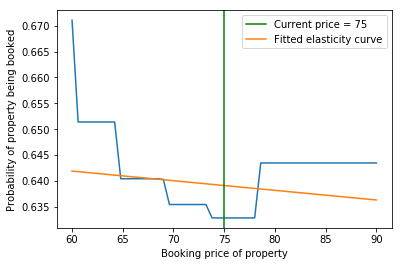

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


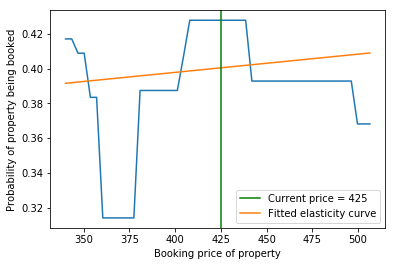

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


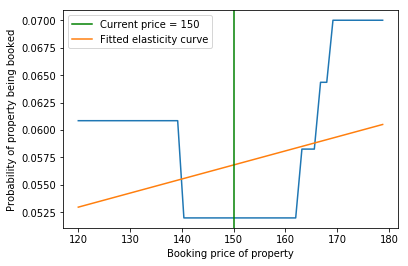

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


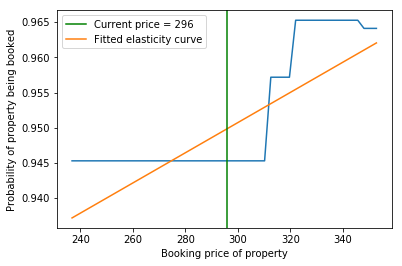

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


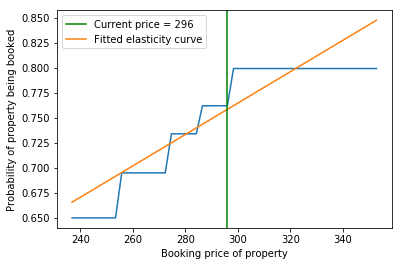

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


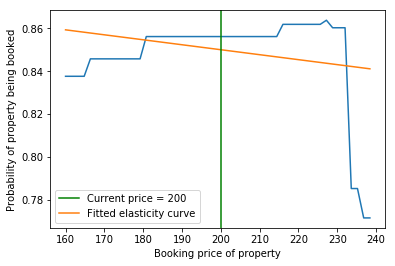

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.8561691
Probability of being booked at higher price: [0.84075793]
Probability of being booked at lower price: [0.85930545]

Current price: 200.0
Probability of being booked at current price: 0.8561691
Expected revenue at current price: 171.23382091522217
Recommended price: 239.0
Probability of booked at recommended price: [0.84094]
Expected revenue at recommended price: [201.15]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.47]%
----------------------------------------------------------------
Checking for price elasticity...


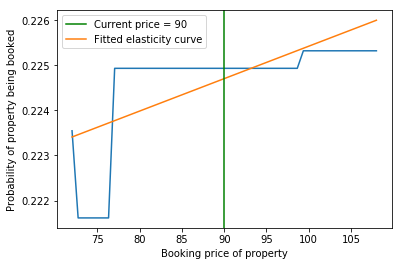

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


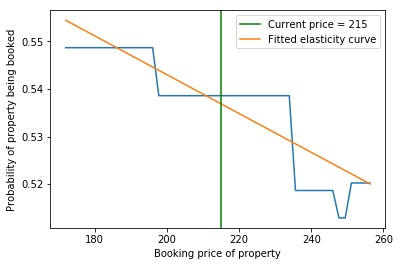

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.5385997
Probability of being booked at higher price: [0.51933783]
Probability of being booked at lower price: [0.55446988]

Current price: 215.0
Probability of being booked at current price: 0.5385997
Expected revenue at current price: 115.79894185066223
Recommended price: 257.0
Probability of booked at recommended price: [0.51969]
Expected revenue at recommended price: [133.63]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [15.4]%
----------------------------------------------------------------
Checking for price elasticity...


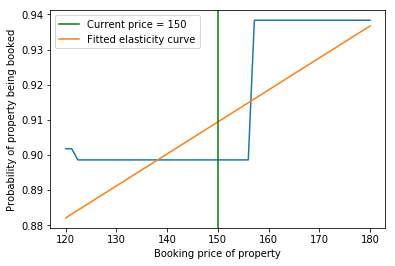

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


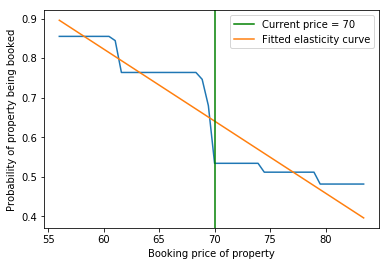

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.53406835
Probability of being booked at higher price: [0.38579864]
Probability of being booked at lower price: [0.8958421]

Current price: 70.0
Probability of being booked at current price: 0.53406835
Expected revenue at current price: 37.38478422164917
Recommended price: 56.0
Probability of booked at recommended price: [0.89584]
Expected revenue at recommended price: [50.17]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [34.19]%
----------------------------------------------------------------
Checking for price elasticity...


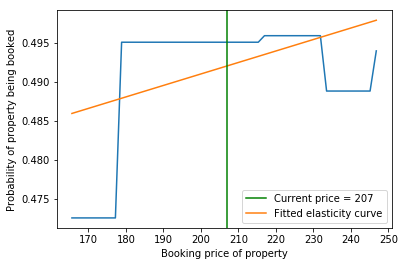

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


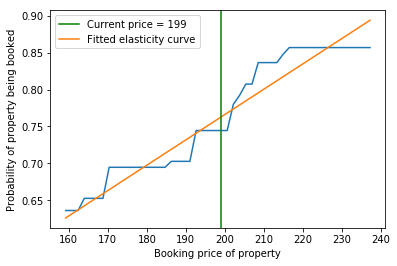

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


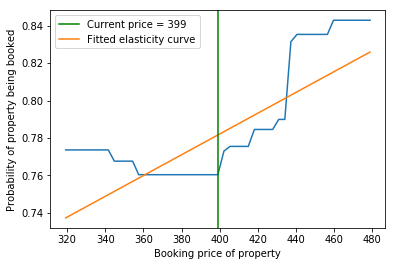

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


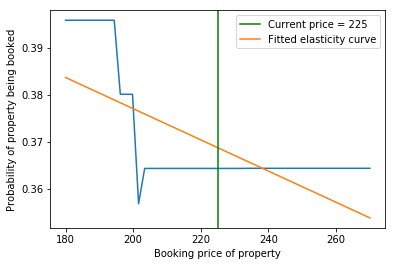

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.36428154
Probability of being booked at higher price: [0.35373238]
Probability of being booked at lower price: [0.38366732]

Current price: 225.0
Probability of being booked at current price: 0.36428154
Expected revenue at current price: 81.96334540843964
Recommended price: 270.0
Probability of booked at recommended price: [0.35373]
Expected revenue at recommended price: [95.51]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [16.52]%
----------------------------------------------------------------
Checking for price elasticity...


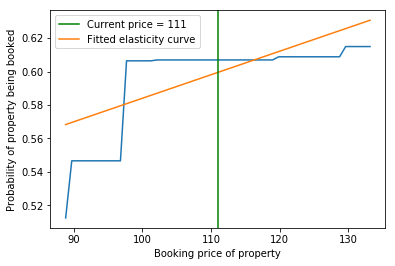

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


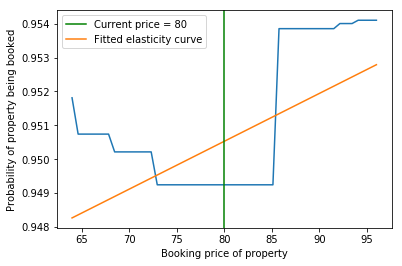

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


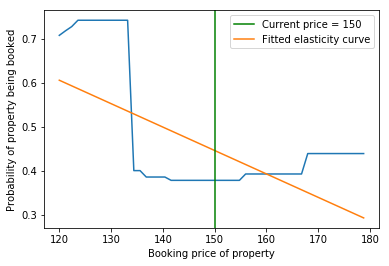

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.37891418
Probability of being booked at higher price: [0.28709273]
Probability of being booked at lower price: [0.60658624]

Current price: 150.0
Probability of being booked at current price: 0.37891418
Expected revenue at current price: 56.83712661266327
Recommended price: 120.0
Probability of booked at recommended price: [0.60659]
Expected revenue at recommended price: [72.79]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [28.07]%
----------------------------------------------------------------
Checking for price elasticity...


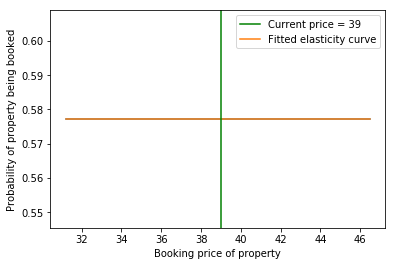

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


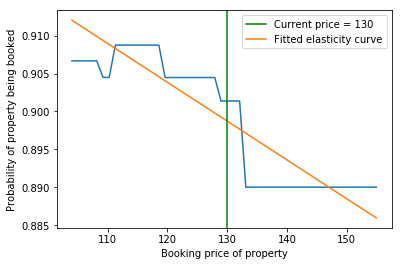

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.90138555
Probability of being booked at higher price: [0.88543358]
Probability of being booked at lower price: [0.91203295]

Current price: 130.0
Probability of being booked at current price: 0.90138555
Expected revenue at current price: 117.1801209449768
Recommended price: 155.0
Probability of booked at recommended price: [0.8857]
Expected revenue at recommended price: [137.71]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.52]%
----------------------------------------------------------------
Checking for price elasticity...


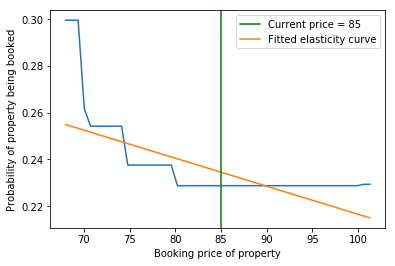

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.22876549
Probability of being booked at higher price: [0.21415159]
Probability of being booked at lower price: [0.25495193]

Current price: 85.0
Probability of being booked at current price: 0.22876549
Expected revenue at current price: 19.445066452026367
Recommended price: 102.0
Probability of booked at recommended price: [0.21456]
Expected revenue at recommended price: [21.81]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [12.17]%
----------------------------------------------------------------
Checking for price elasticity...


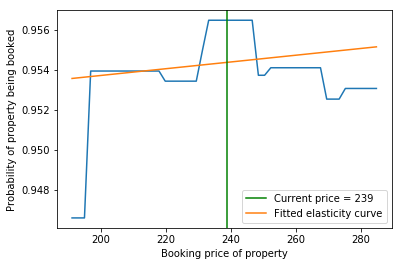

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


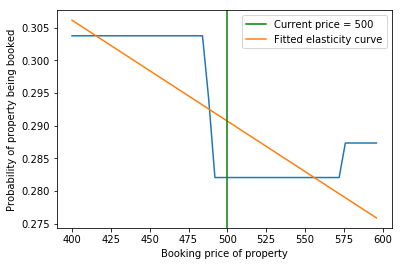

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.28207803
Probability of being booked at higher price: [0.27528302]
Probability of being booked at lower price: [0.3061445]

Current price: 500.0
Probability of being booked at current price: 0.28207803
Expected revenue at current price: 141.0390138626099
Recommended price: 598.0
Probability of booked at recommended price: [0.27559]
Expected revenue at recommended price: [164.8]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [16.85]%
----------------------------------------------------------------
Checking for price elasticity...


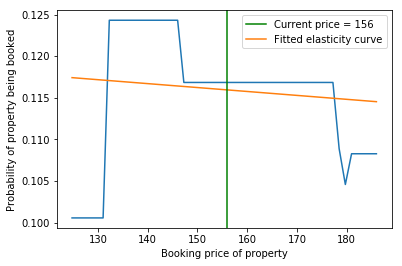

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.11683756
Probability of being booked at higher price: [0.11446915]
Probability of being booked at lower price: [0.11741542]

Current price: 156.0
Probability of being booked at current price: 0.11683756
Expected revenue at current price: 18.226659536361687
Recommended price: 187.0
Probability of booked at recommended price: [0.1145]
Expected revenue at recommended price: [21.36]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.21]%
----------------------------------------------------------------
Checking for price elasticity...


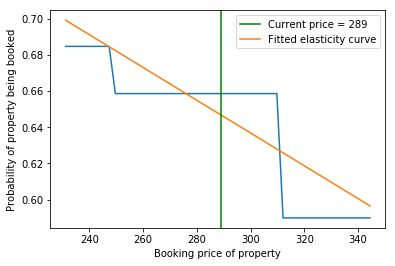

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.6586558
Probability of being booked at higher price: [0.59439778]
Probability of being booked at lower price: [0.69926223]

Current price: 289.0
Probability of being booked at current price: 0.6586558
Expected revenue at current price: 190.35153263807297
Recommended price: 346.0
Probability of booked at recommended price: [0.59545]
Expected revenue at recommended price: [205.81]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [8.12]%
----------------------------------------------------------------
Checking for price elasticity...


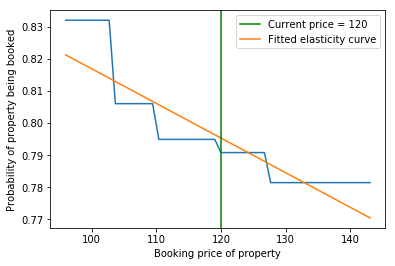

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7908115
Probability of being booked at higher price: [0.76944328]
Probability of being booked at lower price: [0.82122731]

Current price: 120.0
Probability of being booked at current price: 0.7908115
Expected revenue at current price: 94.8973774909973
Recommended price: 144.0
Probability of booked at recommended price: [0.76996]
Expected revenue at recommended price: [110.5]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [16.45]%
----------------------------------------------------------------
Checking for price elasticity...


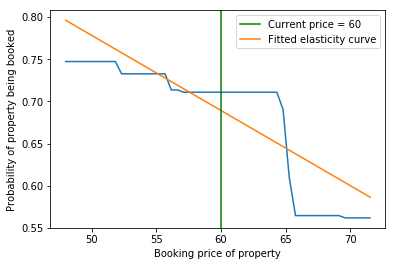

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7108836
Probability of being booked at higher price: [0.58241844]
Probability of being booked at lower price: [0.79606812]

Current price: 60.0
Probability of being booked at current price: 0.7108836
Expected revenue at current price: 42.65301704406739
Recommended price: 69.0
Probability of booked at recommended price: [0.61233]
Expected revenue at recommended price: [42.03]
Percentage of recommended price change: 14.4%
Percentage of change in expected revenue: [-1.46]%
----------------------------------------------------------------
Checking for price elasticity...


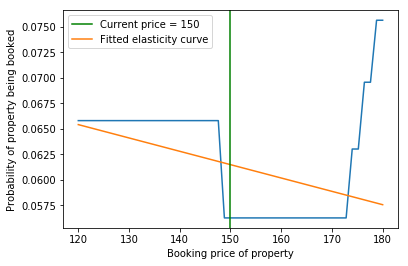

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


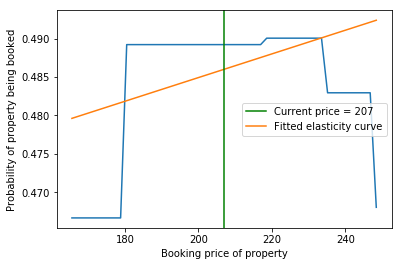

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


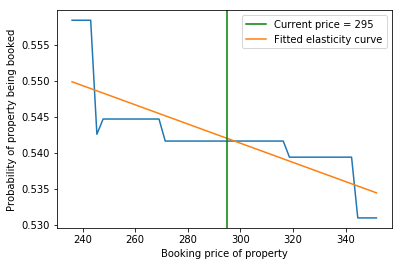

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.54162014
Probability of being booked at higher price: [0.53410653]
Probability of being booked at lower price: [0.54986082]

Current price: 295.0
Probability of being booked at current price: 0.54162014
Expected revenue at current price: 159.77793991565704
Recommended price: 353.0
Probability of booked at recommended price: [0.53426]
Expected revenue at recommended price: [188.5]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [17.98]%
----------------------------------------------------------------
Checking for price elasticity...


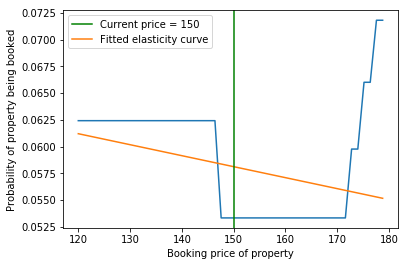

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


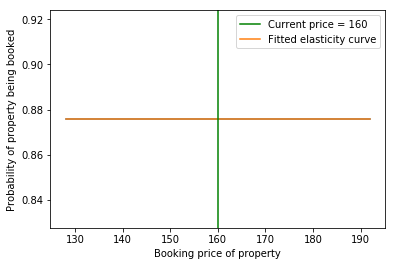

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


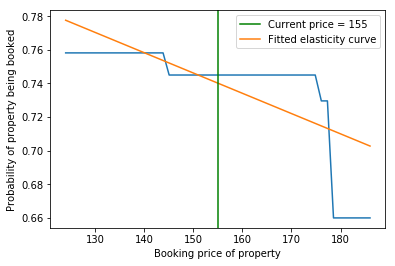

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.7450365
Probability of being booked at higher price: [0.70278543]
Probability of being booked at lower price: [0.77762255]

Current price: 155.0
Probability of being booked at current price: 0.7450365
Expected revenue at current price: 115.48065483570099
Recommended price: 186.0
Probability of booked at recommended price: [0.70279]
Expected revenue at recommended price: [130.72]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [13.19]%
----------------------------------------------------------------
Checking for price elasticity...


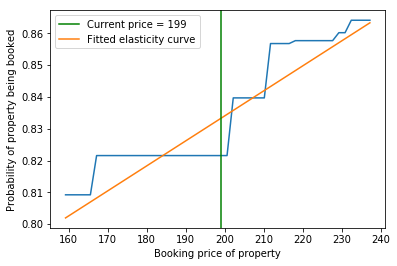

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


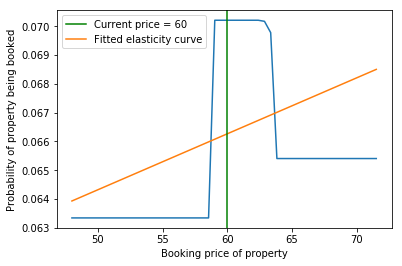

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


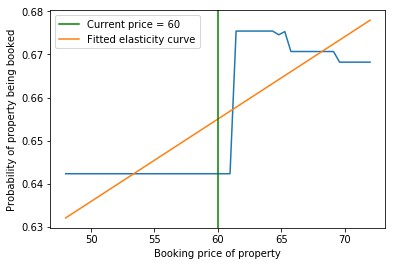

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


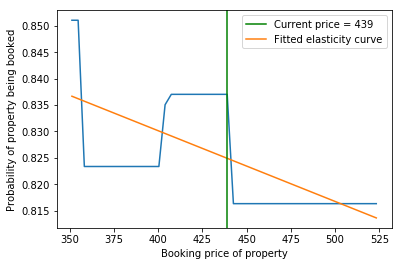

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


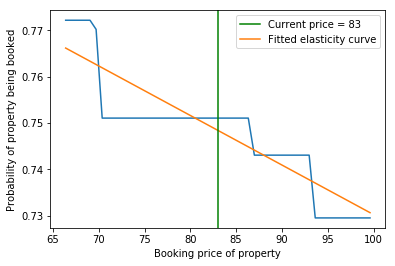

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.75105464
Probability of being booked at higher price: [0.73063473]
Probability of being booked at lower price: [0.76617793]

Current price: 83.0
Probability of being booked at current price: 0.75105464
Expected revenue at current price: 62.33753550052644
Recommended price: 100.0
Probability of booked at recommended price: [0.73063]
Expected revenue at recommended price: [72.77]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [16.74]%
----------------------------------------------------------------
Checking for price elasticity...


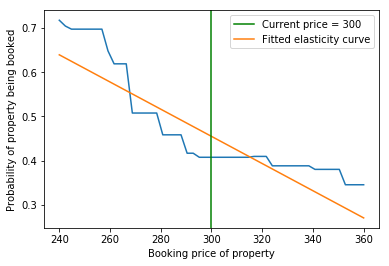

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.40780258
Probability of being booked at higher price: [0.27073862]
Probability of being booked at lower price: [0.6393951]

Current price: 300.0
Probability of being booked at current price: 0.40780258
Expected revenue at current price: 122.34077453613281
Recommended price: 240.0
Probability of booked at recommended price: [0.6394]
Expected revenue at recommended price: [153.45]
Percentage of recommended price change: -20.0%
Percentage of change in expected revenue: [25.43]%
----------------------------------------------------------------
Checking for price elasticity...


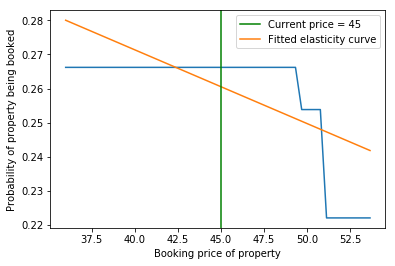

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.2662272
Probability of being booked at higher price: [0.24105993]
Probability of being booked at lower price: [0.28004649]

Current price: 45.0
Probability of being booked at current price: 0.2662272
Expected revenue at current price: 11.98022335767746
Recommended price: 54.0
Probability of booked at recommended price: [0.24145]
Expected revenue at recommended price: [12.99]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [8.47]%
----------------------------------------------------------------
Checking for price elasticity...


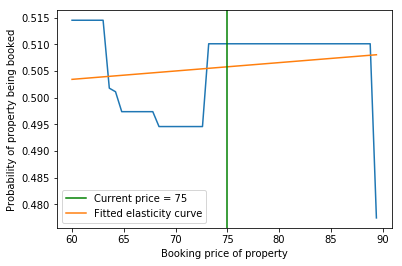

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


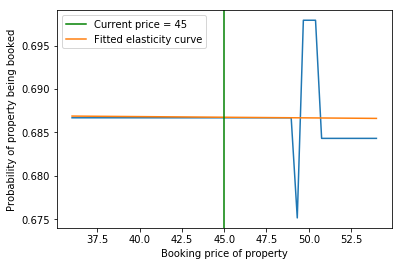

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.6866906
Probability of being booked at higher price: [0.68661999]
Probability of being booked at lower price: [0.68688614]

Current price: 45.0
Probability of being booked at current price: 0.6866906
Expected revenue at current price: 30.901078283786774
Recommended price: 54.0
Probability of booked at recommended price: [0.68662]
Expected revenue at recommended price: [37.08]
Percentage of recommended price change: 20.0%
Percentage of change in expected revenue: [19.99]%
----------------------------------------------------------------
Checking for price elasticity...


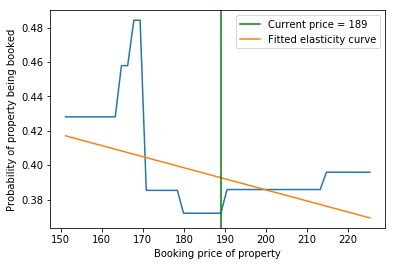

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.3720271
Probability of being booked at higher price: [0.36832644]
Probability of being booked at lower price: [0.41705739]

Current price: 189.0
Probability of being booked at current price: 0.3720271
Expected revenue at current price: 70.31312173604965
Recommended price: 226.0
Probability of booked at recommended price: [0.36881]
Expected revenue at recommended price: [83.37]
Percentage of recommended price change: 19.6%
Percentage of change in expected revenue: [18.57]%
----------------------------------------------------------------
Checking for price elasticity...


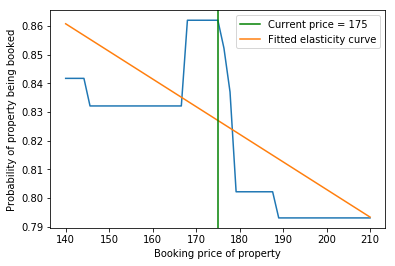

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


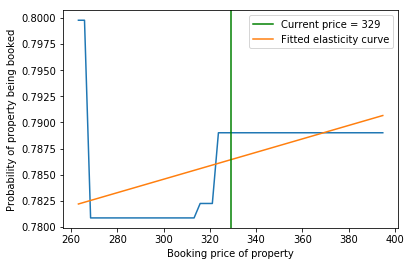

✘ The property does not follow price elasiticity in reasonable price range according to model
Checking for price elasticity...


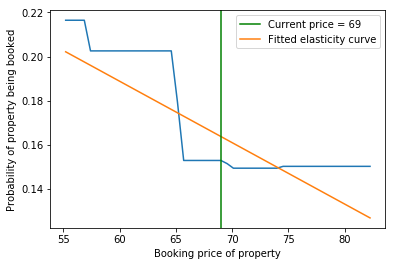

✔ The property follows significant price elasiticity in reasonable price range according to model
Probability of being booked at current price: 0.15298253
Probability of being booked at higher price: [0.12543709]
Probability of being booked at lower price: [0.20217777]

Current price: 69.0
Probability of being booked at current price: 0.15298253
Expected revenue at current price: 10.55579477548599
Recommended price: 64.0
Probability of booked at recommended price: [0.17762]
Expected revenue at recommended price: [11.37]
Percentage of recommended price change: -7.2%
Percentage of change in expected revenue: [7.75]%
----------------------------------------------------------------


In [0]:
expected_revenue_at_current_prices = 0
expected_revenue_at_recommended_prices = 0
number_of_properties_to_be_sampled = 100
number_of_properties_with_price_updated = 0

for index, row in X_test.sample(n=number_of_properties_to_be_sampled, random_state=42).copy().iterrows():  
    expected_revenue_at_current_prices += row["price_calendar_normalized"] * row["total_env_prices"] * calc_prob_booked_xgb(row)
    expected_revenue_at_recommended_prices += calc_revenue_at_tuned_price(row, calc_prob_booked=calc_prob_booked_xgb)
    if np.round(expected_revenue_at_current_prices, 2) != np.round(expected_revenue_at_recommended_prices, 2):
      number_of_properties_with_price_updated += 1

In [0]:
percentage_of_change = 100*(expected_revenue_at_recommended_prices - expected_revenue_at_current_prices)/expected_revenue_at_current_prices
print("After tuning prices, the percentage of change in expected revenue is: " + str(np.round(percentage_of_change, 2)) + "%")

After tuning prices, the percentage of change in expected revenue is: [5.74]%


### Ideas for improvement in accuracy of this predictive model
- Accuracy of predicting the probability of the property getting booked can be further improved by using all the training data availabile for training the Extreme Gradient Boosting model. Currently I have used only 100,000 samples execute my code within memory constraints imposed by Google Colab environment.
- Alternate models like deep neural network can also be utilized with availability of larger dataset and computing resources to train it and choosing the most optimal hyperparameters like number of hidden layers and number of neurons in each layer etc.

This kind of improvements can result in more accurate prediction about the expected revenue from property at given price point.

## Application of this price tuning model based on predictive analysis
There might be a limitation for **Airbnb** based on its business policy where prices are largely set by property owners and there is a less room for Airbnb to experiment with difference price points of a property to gather sufficient data to understand price elasticity of each property for its demand.

Booking companies like **Booking.com**, **Trivago** and **OYO** can benefit from such kind of predictive price tuning model because they have more control over the booking price of the hotel room. Such a company can easily look at its past data of having each room offered at different prices and estimating the price elasticity for demand for each hotel room of some type. It can then train a predictive model for estimating the probability of a property getting booked at given price point on given day and market scenario. After calculating the price elasticity for given property, it can then tune the price of the hotel room type using above suggested method such that it maximizes expected revenue from that hotel room type on given day.